# REALTIME ARCANE

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
#Set devices_id
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]=""
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()

logger.info("Loading packages...")

2023-04-24 15:30:16,573 | INFO : Loading packages...


In [3]:
from config import get_config
from models.model import model_factory
from datasets.data import data_factory_fun
from utils.datagen import UnetGen
from datasets import event as evt
from utils import utils

import json
import pandas as pds
import numpy as np


from datetime import datetime

conf = get_config("")
conf.update(resampling='1T')
#conf.update(spacecraft='Wind_Archive')
#conf.update(data_window_len=2048)
conf.update(experiment_name='ARCANE_highres')
#conf.update(pretrain='True')
#conf.update(reduce_factor=2)
#conf.update(res_depth=3)
conf.update(earlystopping_patience=10)
conf.update(spacecraft='DSCVR')
#conf.update(split='custom')
conf.update(train='True')
conf.update(realtime='True')
conf.update(finetune='False')
conf.update(schedule='custom_schedule')
conf.update(earlystopping_patience=25)
conf.update(GPU='1')
#conf.update(seed=None)

initial_timestamp = datetime.now()
output_dir = conf['output_dir']
if not os.path.isdir(output_dir):
    raise IOError(
        "Root directory '{}', where the directory of the experiment will be created, must exist".format(output_dir))

output_dir = os.path.join(output_dir, conf['experiment_name'])

formatted_timestamp = initial_timestamp.strftime("%Y-%m-%d_%H-%M-%S")
conf['initial_timestamp'] = formatted_timestamp
conf['output_dir'] = output_dir
conf['save_dir'] = os.path.join(output_dir, 'checkpoints')
conf['model_dir'] = os.path.join(output_dir, 'complete_saved_model')    
conf['pred_dir'] = os.path.join(output_dir, 'predictions')
utils.create_dirs([conf['save_dir'], conf['pred_dir']]) #, config['tensorboard_dir']

# Save configuration as a (pretty) json file
with open(os.path.join(output_dir, 'configuration.json'), 'w') as fp:
    json.dump(conf, fp, indent=4, sort_keys=True)

logger.info("Stored configuration file in '{}'".format(output_dir))

2023-04-24 15:30:20,343 | INFO : Stored configuration file in 'output/ARCANE_highres'


In [4]:
import time
import tensorflow as tf
import random

total_start_time = time.time()
tf.config.list_physical_devices('GPU')

tf.random.set_seed(69)

### Data Preprocessing

In [5]:
data = data_factory_fun(conf)

2023-04-24 15:30:20,467 | INFO : Loading Helio4cast catalog...
2023-04-24 15:30:20,480 | INFO : Loading data...
2023-04-24 15:30:20,504 | INFO : Preprocessing data...
2023-04-24 15:30:22,107 | INFO : Deleting empty events and removing eventless data...
2023-04-24 15:30:22,159 | INFO : data for 2016 added
2023-04-24 15:30:22,228 | INFO : data for 2017 added
2023-04-24 15:30:22,299 | INFO : data for 2018 added
2023-04-24 15:30:22,365 | INFO : data for 2019 added
2023-04-24 15:30:22,443 | INFO : data for 2020 added
2023-04-24 15:30:22,518 | INFO : data for 2021 added
2023-04-24 15:30:22,604 | INFO : data for 2022 added
2023-04-24 15:30:22,624 | INFO : Creating label...
2023-04-24 15:30:27,372 | INFO : Scaling data...
2023-04-24 15:30:27,528 | INFO : Splitting data...
2023-04-24 15:30:27,529 | INFO : Using automatic splitting rule...
2023-04-24 15:30:27,529 | INFO : Splits consist of the following groups:
2023-04-24 15:30:27,529 | INFO : [[2016, 2021], [2017], [2018], [2019, 2022], [2020]]

In [6]:
data.all_df

,bx,by,bz,bt,np,vt,tp,beta,pdyn,texrat
2016-07-26 00:00:00,-2.30,1.64,-0.06,2.84,7.35,374.899994,12595.0,0.398265,1.727889e-09,0.296108
2016-07-26 00:01:00,-2.26,1.83,0.00,2.91,7.32,374.600006,12567.0,0.376947,1.718084e-09,0.296294
2016-07-26 00:02:00,-2.50,1.66,-0.13,3.01,7.22,374.500000,12615.0,0.348831,1.693708e-09,0.297709
2016-07-26 00:03:00,-2.76,1.21,-0.29,3.03,7.30,374.799988,12692.0,0.350180,1.715220e-09,0.298672
2016-07-26 00:04:00,-2.71,1.45,-0.12,3.08,7.19,375.000000,12473.0,0.328036,1.691178e-09,0.292961
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,-1.77,5.22,-0.04,5.66,12.30,572.099976,650456.0,8.665894,6.733591e-09,4.074372
2022-12-31 23:56:00,-1.68,4.42,1.45,5.62,12.20,586.500000,637659.0,8.546708,7.019297e-09,3.726263
2022-12-31 23:57:00,-3.62,3.73,1.29,5.55,11.71,565.000000,562824.0,7.424490,6.252469e-09,3.651567
2022-12-31 23:58:00,-3.04,4.11,2.09,5.57,13.40,565.500000,673855.0,10.099131,7.167501e-09,4.361032


In [7]:
data.X_train

,beta,bt,bx,by,bz,np,pdyn,texrat,tp,vt
2018-01-01 00:00:00,-0.287535,1.693501,1.964519,0.772174,-2.005157,1.743133,1.197591,-0.219326,-0.394665,-0.193153
2018-01-01 00:01:00,-0.299260,1.790321,2.335308,0.197757,-1.829680,1.669504,1.158176,-0.279411,-0.421797,-0.178743
2018-01-01 00:02:00,-0.315353,1.817431,2.459893,0.206082,-1.710488,1.660841,1.169098,-0.436069,-0.502660,-0.164333
2018-01-01 00:03:00,-0.315050,1.887142,2.510320,0.322630,-1.710488,1.682497,1.161977,-0.402097,-0.489943,-0.183889
2018-01-01 00:04:00,-0.322650,2.073038,2.587444,0.494678,-1.803193,1.613199,1.111739,-0.408036,-0.492227,-0.180801
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,1.123682,0.171478,-0.550911,1.482564,0.014490,1.015504,2.622764,1.130455,2.484019,1.492801
2022-12-31 23:56:00,1.102970,0.155987,-0.524214,1.260567,0.507813,0.993849,2.794792,0.939374,2.418023,1.641017
2022-12-31 23:57:00,0.907953,0.128877,-1.099678,1.069095,0.454839,0.887736,2.333073,0.898372,2.032092,1.419722
2022-12-31 23:58:00,1.372747,0.136622,-0.927632,1.174544,0.719710,1.253716,2.884028,1.287807,2.604690,1.424869


In [8]:
for i in range (4):
    print(str(data.evtlist[i])) # each event is stored in a list with "begin" and "end"

2022-09-30 04:50:00 ---> 2022-10-01 14:04:00
2022-09-14 19:28:00 ---> 2022-09-15 13:34:00
2022-07-18 20:26:00 ---> 2022-07-20 09:22:00
2022-07-08 06:40:00 ---> 2022-07-08 18:04:00


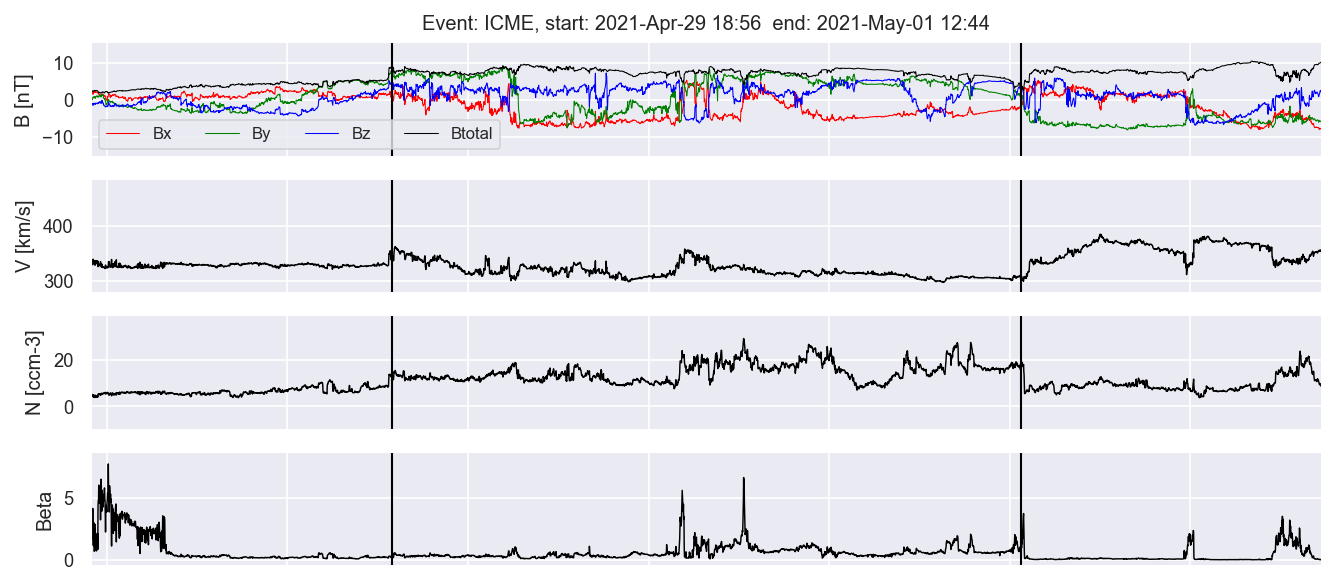

In [9]:
data.evtlist[42].iwfplotnopred(data.all_df, 20, 'Event: ')

In [10]:
data.labels_df

,ICME
2016-07-26 00:00:00,0.0
2016-07-26 00:01:00,0.0
2016-07-26 00:02:00,0.0
2016-07-26 00:03:00,0.0
2016-07-26 00:04:00,0.0
...,...
2022-12-31 23:55:00,0.0
2022-12-31 23:56:00,0.0
2022-12-31 23:57:00,0.0
2022-12-31 23:58:00,0.0


### Model and Data Generator

In [11]:
model, callbacks = model_factory(conf, data)

2023-04-24 15:30:29,103 | INFO : Feature dimension equals 10
2023-04-24 15:30:29,104 | INFO : Sequence length equals 1024
2023-04-24 15:30:29,104 | INFO : Image size equals (1024, 1, 10)
2023-04-24 15:30:29,104 | INFO : Choosing model architecture: ResUNet
2023-04-24 15:30:29,105 | INFO : Building model for Seq2Seq
2023-04-24 15:30:29.176644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 15:30:29.176756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2023-04-24 15:30:29,780 | INFO : Created ResUNet!
2023-04-24 15:30:29,780 | INFO : Selecting optimizer
2023-04-24 15:30:29,780 | INFO : Setting Adam optimizer...
2023-04-24 15:30:29,780 | INFO : Selecting metrics
2023-04-24 15:30:29,789 | INFO : Selecting loss
2023-04-24 15:30:29,789 | INFO : Compiling model...
2023-04-24 15:30:29,795 | INFO : Setting callbacks...
2023-04-24 15:30:29,795 | INFO : Early Stopping will be done after 25 epochs of no improvement


In [12]:
callbacks

In [13]:
train_gen = UnetGen('train', conf, data)
val_gen = UnetGen('val', conf, data)

2023-04-24 15:30:29,883 | INFO : Initializing data generator for training...
2023-04-24 15:30:29,883 | INFO : Initializing data generator for validation...


In [14]:
import tensorflow as tf

history = model.fit(train_gen,validation_data=val_gen,epochs=conf['epochs'],callbacks=callbacks)

2023-04-24 15:30:29.978799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/400


2023-04-24 15:30:31.284773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 38/443 [=>............................] - ETA: 11:20 - loss: 0.6951 - accuracy: 0.0149 - recall: 0.5646 - precision: 0.1907 - dice_coef: 0.3049 - true_skill_score: 0.4893 - mean_io_u: 0.5789

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34cf379e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


320/443 [====================>.........] - ETA: 42:35 - loss: 0.6768 - accuracy: 0.0147 - recall: 0.4971 - precision: 0.1796 - dice_coef: 0.3232 - true_skill_score: 0.4958 - mean_io_u: 0.5930

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2b8136930>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


345/443 [======================>.......] - ETA: 31:39 - loss: 0.6703 - accuracy: 0.0148 - recall: 0.5063 - precision: 0.1878 - dice_coef: 0.3297 - true_skill_score: 0.5041 - mean_io_u: 0.5948

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2b898dbc0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


438/443 [============================>.] - ETA: 1:18 - loss: 0.6611 - accuracy: 0.0142 - recall: 0.5080 - precision: 0.2075 - dice_coef: 0.3389 - true_skill_score: 0.5263 - mean_io_u: 0.5974

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2b9a406a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


442/443 [============================>.] - ETA: 15s - loss: 0.6616 - accuracy: 0.0141 - recall: 0.5087 - precision: 0.2072 - dice_coef: 0.3384 - true_skill_score: 0.5285 - mean_io_u: 0.5971   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2b9856650>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.0141 - recall: 0.5087 - precision: 0.2067 - dice_coef: 0.3376 - true_skill_score: 0.5293 - mean_io_u: 0.5971 

2023-04-24 17:24:31.640457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x39922ace0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x34cacabc0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQu


Epoch 1: val_loss improved from inf to 0.83659, saving model to output/ARCANE_highres/checkpoints/resunet_seq2seq_1


2023-04-24 17:25:38,409 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-24 17:25:39,954 | INFO : Assets written to: output/ARCANE_highres/checkpoints/resunet_seq2seq_1/assets


443/443 [==============================] - 6911s 16s/step - loss: 0.6624 - accuracy: 0.0141 - recall: 0.5087 - precision: 0.2067 - dice_coef: 0.3376 - true_skill_score: 0.5293 - mean_io_u: 0.5971 - val_loss: 0.8366 - val_accuracy: 0.0050 - val_recall: 0.2864 - val_precision: 0.1915 - val_dice_coef: 0.1634 - val_true_skill_score: 0.4268 - val_mean_io_u: 0.5533 - lr: 0.0010
Epoch 2/400
 46/443 [==>...........................] - ETA: 9:47 - loss: 0.6083 - accuracy: 0.0212 - recall: 0.7134 - precision: 0.2986 - dice_coef: 0.3917 - true_skill_score: 0.6923 - mean_io_u: 0.6183

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x39f8991c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


167/443 [==========>...................] - ETA: 7:37 - loss: 0.5954 - accuracy: 0.0160 - recall: 0.6077 - precision: 0.3342 - dice_coef: 0.4046 - true_skill_score: 0.6322 - mean_io_u: 0.6260

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28252cc20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.0156 - recall: 0.5751 - precision: 0.3418 - dice_coef: 0.3934 - true_skill_score: 0.6086 - mean_io_u: 0.6215
Epoch 2: val_loss improved from 0.83659 to 0.79670, saving model to output/ARCANE_highres/checkpoints/resunet_seq2seq_1


2023-04-24 17:39:04,380 | WARNING : Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 32). These functions will not be directly callable after loading.
2023-04-24 17:39:06,067 | INFO : Assets written to: output/ARCANE_highres/checkpoints/resunet_seq2seq_1/assets


443/443 [==============================] - 806s 2s/step - loss: 0.6066 - accuracy: 0.0156 - recall: 0.5751 - precision: 0.3418 - dice_coef: 0.3934 - true_skill_score: 0.6086 - mean_io_u: 0.6215 - val_loss: 0.7967 - val_accuracy: 0.0066 - val_recall: 0.3398 - val_precision: 0.2666 - val_dice_coef: 0.2033 - val_true_skill_score: 0.3886 - val_mean_io_u: 0.5714 - lr: 0.0012
Epoch 3/400
 71/443 [===>..........................] - ETA: 10:32 - loss: 0.5688 - accuracy: 0.0172 - recall: 0.6085 - precision: 0.4084 - dice_coef: 0.4312 - true_skill_score: 0.6530 - mean_io_u: 0.6635

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0x3729cb890>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


156/443 [=========>....................] - ETA: 8:09 - loss: 0.6913 - accuracy: 0.0155 - recall: 0.5256 - precision: 0.1880 - dice_coef: 0.3087 - true_skill_score: 0.5323 - mean_io_u: 0.5668

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x280e57a90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


167/443 [==========>...................] - ETA: 7:51 - loss: 0.6956 - accuracy: 0.0152 - recall: 0.5213 - precision: 0.1903 - dice_coef: 0.3044 - true_skill_score: 0.5321 - mean_io_u: 0.5674

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f77b4e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


168/443 [==========>...................] - ETA: 7:50 - loss: 0.6929 - accuracy: 0.0153 - recall: 0.5225 - precision: 0.1921 - dice_coef: 0.3071 - true_skill_score: 0.5328 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x284b989f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


177/443 [==========>...................] - ETA: 7:37 - loss: 0.6944 - accuracy: 0.0155 - recall: 0.5133 - precision: 0.1938 - dice_coef: 0.3056 - true_skill_score: 0.5204 - mean_io_u: 0.5681

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x39e4743f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


180/443 [===========>..................] - ETA: 7:33 - loss: 0.6994 - accuracy: 0.0154 - recall: 0.5127 - precision: 0.1926 - dice_coef: 0.3006 - true_skill_score: 0.5223 - mean_io_u: 0.5680

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3ddcb24c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


200/443 [============>.................] - ETA: 6:58 - loss: 0.7049 - accuracy: 0.0147 - recall: 0.4929 - precision: 0.1974 - dice_coef: 0.2951 - true_skill_score: 0.5135 - mean_io_u: 0.5677

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28490cd90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


231/443 [==============>...............] - ETA: 6:03 - loss: 0.7174 - accuracy: 0.0138 - recall: 0.4834 - precision: 0.2007 - dice_coef: 0.2826 - true_skill_score: 0.5143 - mean_io_u: 0.5681

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x284c3b630>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


244/443 [===============>..............] - ETA: 5:42 - loss: 0.7142 - accuracy: 0.0138 - recall: 0.4811 - precision: 0.2068 - dice_coef: 0.2858 - true_skill_score: 0.5142 - mean_io_u: 0.5694

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28436d8b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


256/443 [================>.............] - ETA: 5:22 - loss: 0.7088 - accuracy: 0.0138 - recall: 0.4802 - precision: 0.2164 - dice_coef: 0.2912 - true_skill_score: 0.5119 - mean_io_u: 0.5696

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3a0029ad0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


275/443 [=================>............] - ETA: 4:49 - loss: 0.7079 - accuracy: 0.0136 - recall: 0.4735 - precision: 0.2192 - dice_coef: 0.2921 - true_skill_score: 0.5138 - mean_io_u: 0.5702

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x284c61560>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


286/443 [==================>...........] - ETA: 4:31 - loss: 0.7078 - accuracy: 0.0135 - recall: 0.4748 - precision: 0.2213 - dice_coef: 0.2922 - true_skill_score: 0.5126 - mean_io_u: 0.5701

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x284955890>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


361/443 [=======================>......] - ETA: 2:20 - loss: 0.7082 - accuracy: 0.0129 - recall: 0.4656 - precision: 0.2285 - dice_coef: 0.2918 - true_skill_score: 0.5121 - mean_io_u: 0.5697

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2e3b2dbf0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


365/443 [=======================>......] - ETA: 2:13 - loss: 0.7095 - accuracy: 0.0128 - recall: 0.4653 - precision: 0.2287 - dice_coef: 0.2905 - true_skill_score: 0.5135 - mean_io_u: 0.5695

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2bc6424e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


366/443 [=======================>......] - ETA: 2:11 - loss: 0.7085 - accuracy: 0.0129 - recall: 0.4658 - precision: 0.2294 - dice_coef: 0.2915 - true_skill_score: 0.5137 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2e3b57310>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


375/443 [========================>.....] - ETA: 1:56 - loss: 0.7089 - accuracy: 0.0129 - recall: 0.4642 - precision: 0.2306 - dice_coef: 0.2911 - true_skill_score: 0.5166 - mean_io_u: 0.5700

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2822f3bb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


382/443 [========================>.....] - ETA: 1:44 - loss: 0.7082 - accuracy: 0.0129 - recall: 0.4603 - precision: 0.2328 - dice_coef: 0.2918 - true_skill_score: 0.5148 - mean_io_u: 0.5694

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2822ccf40>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


428/443 [===========================>..] - ETA: 25s - loss: 0.7172 - accuracy: 0.0128 - recall: 0.4572 - precision: 0.2181 - dice_coef: 0.2828 - true_skill_score: 0.5004 - mean_io_u: 0.5630

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2bc6adfa0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


430/443 [============================>.] - ETA: 22s - loss: 0.7178 - accuracy: 0.0128 - recall: 0.4590 - precision: 0.2156 - dice_coef: 0.2822 - true_skill_score: 0.5005 - mean_io_u: 0.5630    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283d88170>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


441/443 [============================>.] - ETA: 3s - loss: 0.7190 - accuracy: 0.0127 - recall: 0.4629 - precision: 0.2135 - dice_coef: 0.2810 - true_skill_score: 0.4976 - mean_io_u: 0.5623

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283d90f80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.0127 - recall: 0.4622 - precision: 0.2129 - dice_coef: 0.2800 - true_skill_score: 0.4957 - mean_io_u: 0.5623 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x39f592960>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2e3833740>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    r


Epoch 3: val_loss did not improve from 0.79670
443/443 [==============================] - 826s 2s/step - loss: 0.7200 - accuracy: 0.0127 - recall: 0.4622 - precision: 0.2129 - dice_coef: 0.2800 - true_skill_score: 0.4957 - mean_io_u: 0.5623 - val_loss: 0.9775 - val_accuracy: 0.0039 - val_recall: 0.0126 - val_precision: 0.0512 - val_dice_coef: 0.0225 - val_true_skill_score: 0.1687 - val_mean_io_u: 0.4897 - lr: 0.0015
Epoch 4/400
 51/443 [==>...........................] - ETA: 11:01 - loss: 0.7958 - accuracy: 0.0068 - recall: 0.4817 - precision: 0.1497 - dice_coef: 0.2042 - true_skill_score: 0.4825 - mean_io_u: 0.5186

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2837fa6e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


100/443 [=====>........................] - ETA: 9:46 - loss: 0.8229 - accuracy: 0.0090 - recall: 0.5045 - precision: 0.1139 - dice_coef: 0.1771 - true_skill_score: 0.4829 - mean_io_u: 0.5151

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2835734f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


130/443 [=======>......................] - ETA: 9:00 - loss: 0.8189 - accuracy: 0.0085 - recall: 0.5155 - precision: 0.1170 - dice_coef: 0.1811 - true_skill_score: 0.5021 - mean_io_u: 0.5118

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2e393d940>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


131/443 [=======>......................] - ETA: 8:59 - loss: 0.8184 - accuracy: 0.0084 - recall: 0.5165 - precision: 0.1174 - dice_coef: 0.1816 - true_skill_score: 0.5018 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2e3918490>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


169/443 [==========>...................] - ETA: 7:56 - loss: 0.8121 - accuracy: 0.0080 - recall: 0.5346 - precision: 0.1246 - dice_coef: 0.1879 - true_skill_score: 0.5176 - mean_io_u: 0.5107

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3997816a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


224/443 [==============>...............] - ETA: 6:18 - loss: 0.8212 - accuracy: 0.0083 - recall: 0.5064 - precision: 0.1197 - dice_coef: 0.1788 - true_skill_score: 0.5000 - mean_io_u: 0.5113

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f63ab90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


233/443 [==============>...............] - ETA: 6:01 - loss: 0.8255 - accuracy: 0.0080 - recall: 0.4818 - precision: 0.1194 - dice_coef: 0.1745 - true_skill_score: 0.4863 - mean_io_u: 0.5099

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28386d9b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


281/443 [==================>...........] - ETA: 4:38 - loss: 0.8246 - accuracy: 0.0076 - recall: 0.4469 - precision: 0.1225 - dice_coef: 0.1754 - true_skill_score: 0.4679 - mean_io_u: 0.5123

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2839603f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


336/443 [=====================>........] - ETA: 3:03 - loss: 0.8091 - accuracy: 0.0086 - recall: 0.4676 - precision: 0.1323 - dice_coef: 0.1909 - true_skill_score: 0.4803 - mean_io_u: 0.5184

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x281d0ab30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.7834 - accuracy: 0.0109 - recall: 0.4986 - precision: 0.1536 - dice_coef: 0.2166 - true_skill_score: 0.4960 - mean_io_u: 0.5276

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x284814a60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28483e330>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    r


Epoch 4: val_loss did not improve from 0.79670
443/443 [==============================] - 797s 2s/step - loss: 0.7834 - accuracy: 0.0109 - recall: 0.4986 - precision: 0.1536 - dice_coef: 0.2166 - true_skill_score: 0.4960 - mean_io_u: 0.5276 - val_loss: 0.9127 - val_accuracy: 0.0026 - val_recall: 0.2745 - val_precision: 0.0724 - val_dice_coef: 0.0873 - val_true_skill_score: 0.2986 - val_mean_io_u: 0.5152 - lr: 0.0018
Epoch 5/400
 47/443 [==>...........................] - ETA: 10:53 - loss: 0.7765 - accuracy: 0.0205 - recall: 0.5902 - precision: 0.1556 - dice_coef: 0.2235 - true_skill_score: 0.5893 - mean_io_u: 0.5476

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2842e6310>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.0188 - recall: 0.5192 - precision: 0.1991 - dice_coef: 0.2538 - true_skill_score: 0.5531 - mean_io_u: 0.5478
Epoch 5: val_loss did not improve from 0.79670
443/443 [==============================] - 1758s 4s/step - loss: 0.7462 - accuracy: 0.0188 - recall: 0.5192 - precision: 0.1991 - dice_coef: 0.2538 - true_skill_score: 0.5531 - mean_io_u: 0.5478 - val_loss: 0.9011 - val_accuracy: 0.0032 - val_recall: 0.1923 - val_precision: 0.1206 - val_dice_coef: 0.0989 - val_true_skill_score: 0.3340 - val_mean_io_u: 0.5059 - lr: 0.0022
Epoch 6/400
142/443 [========>.....................] - ETA: 14:50 - loss: 0.7032 - accuracy: 0.0270 - recall: 0.5258 - precision: 0.2517 - dice_coef: 0.2968 - true_skill_score: 0.4970 - mean_io_u: 0.5662

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2845f2990>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


143/443 [========>.....................] - ETA: 14:49 - loss: 0.7025 - accuracy: 0.0271 - recall: 0.5256 - precision: 0.2522 - dice_coef: 0.2975 - true_skill_score: 0.4967 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f480a90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


144/443 [========>.....................] - ETA: 14:47 - loss: 0.7008 - accuracy: 0.0271 - recall: 0.5282 - precision: 0.2531 - dice_coef: 0.2992 - true_skill_score: 0.4999 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a0f060>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


145/443 [========>.....................] - ETA: 14:46 - loss: 0.6998 - accuracy: 0.0273 - recall: 0.5314 - precision: 0.2534 - dice_coef: 0.3002 - true_skill_score: 0.5028 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2845eeca0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


147/443 [========>.....................] - ETA: 14:44 - loss: 0.7004 - accuracy: 0.0273 - recall: 0.5313 - precision: 0.2548 - dice_coef: 0.2996 - true_skill_score: 0.4992 - mean_io_u: 0.5664    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2855978a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


148/443 [=========>....................] - ETA: 14:42 - loss: 0.6957 - accuracy: 0.0275 - recall: 0.5344 - precision: 0.2572 - dice_coef: 0.3043 - true_skill_score: 0.5026 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2855cc1a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


149/443 [=========>....................] - ETA: 14:40 - loss: 0.6965 - accuracy: 0.0275 - recall: 0.5329 - precision: 0.2564 - dice_coef: 0.3035 - true_skill_score: 0.5009 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2845e6030>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


150/443 [=========>....................] - ETA: 14:39 - loss: 0.6985 - accuracy: 0.0274 - recall: 0.5329 - precision: 0.2552 - dice_coef: 0.3015 - true_skill_score: 0.5039 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cbb3f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


151/443 [=========>....................] - ETA: 14:38 - loss: 0.6979 - accuracy: 0.0274 - recall: 0.5345 - precision: 0.2551 - dice_coef: 0.3021 - true_skill_score: 0.5068 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2855f2420>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


152/443 [=========>....................] - ETA: 14:37 - loss: 0.6995 - accuracy: 0.0274 - recall: 0.5347 - precision: 0.2537 - dice_coef: 0.3005 - true_skill_score: 0.5096 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283fcb070>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


153/443 [=========>....................] - ETA: 14:35 - loss: 0.6985 - accuracy: 0.0275 - recall: 0.5339 - precision: 0.2547 - dice_coef: 0.3015 - true_skill_score: 0.5090 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ccdd60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


154/443 [=========>....................] - ETA: 14:35 - loss: 0.7005 - accuracy: 0.0276 - recall: 0.5339 - precision: 0.2533 - dice_coef: 0.2995 - true_skill_score: 0.5118 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ccdad0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


155/443 [=========>....................] - ETA: 14:34 - loss: 0.7001 - accuracy: 0.0275 - recall: 0.5343 - precision: 0.2533 - dice_coef: 0.2999 - true_skill_score: 0.5122 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cc3f20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


156/443 [=========>....................] - ETA: 14:34 - loss: 0.6986 - accuracy: 0.0277 - recall: 0.5358 - precision: 0.2547 - dice_coef: 0.3014 - true_skill_score: 0.5129 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2803f2fb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


157/443 [=========>....................] - ETA: 14:33 - loss: 0.6964 - accuracy: 0.0277 - recall: 0.5388 - precision: 0.2562 - dice_coef: 0.3036 - true_skill_score: 0.5158 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f49a560>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


158/443 [=========>....................] - ETA: 14:32 - loss: 0.6983 - accuracy: 0.0276 - recall: 0.5388 - precision: 0.2553 - dice_coef: 0.3017 - true_skill_score: 0.5187 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd3ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


159/443 [=========>....................] - ETA: 14:31 - loss: 0.7002 - accuracy: 0.0275 - recall: 0.5331 - precision: 0.2534 - dice_coef: 0.2998 - true_skill_score: 0.5149 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283fc4c80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


160/443 [=========>....................] - ETA: 14:30 - loss: 0.7006 - accuracy: 0.0275 - recall: 0.5248 - precision: 0.2540 - dice_coef: 0.2994 - true_skill_score: 0.5125 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283fd9f30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


162/443 [=========>....................] - ETA: 14:27 - loss: 0.6969 - accuracy: 0.0276 - recall: 0.5265 - precision: 0.2570 - dice_coef: 0.3031 - true_skill_score: 0.5143 - mean_io_u: 0.5662    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2855fb980>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


163/443 [==========>...................] - ETA: 14:25 - loss: 0.6988 - accuracy: 0.0274 - recall: 0.5242 - precision: 0.2564 - dice_coef: 0.3012 - true_skill_score: 0.5110 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdb210>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


164/443 [==========>...................] - ETA: 14:25 - loss: 0.7006 - accuracy: 0.0273 - recall: 0.5242 - precision: 0.2559 - dice_coef: 0.2994 - true_skill_score: 0.5139 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2855bf1f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


165/443 [==========>...................] - ETA: 14:24 - loss: 0.7024 - accuracy: 0.0272 - recall: 0.5212 - precision: 0.2554 - dice_coef: 0.2976 - true_skill_score: 0.5106 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdb320>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


166/443 [==========>...................] - ETA: 14:23 - loss: 0.7034 - accuracy: 0.0271 - recall: 0.5134 - precision: 0.2556 - dice_coef: 0.2966 - true_skill_score: 0.5079 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283fe5680>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


167/443 [==========>...................] - ETA: 14:22 - loss: 0.7052 - accuracy: 0.0269 - recall: 0.5104 - precision: 0.2552 - dice_coef: 0.2948 - true_skill_score: 0.5048 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d520f00>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


168/443 [==========>...................] - ETA: 14:20 - loss: 0.7036 - accuracy: 0.0269 - recall: 0.5101 - precision: 0.2563 - dice_coef: 0.2964 - true_skill_score: 0.5045 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d520f00>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


169/443 [==========>...................] - ETA: 14:19 - loss: 0.7031 - accuracy: 0.0268 - recall: 0.5072 - precision: 0.2573 - dice_coef: 0.2969 - true_skill_score: 0.5031 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30561f190>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


170/443 [==========>...................] - ETA: 14:18 - loss: 0.7024 - accuracy: 0.0268 - recall: 0.5055 - precision: 0.2581 - dice_coef: 0.2976 - true_skill_score: 0.5019 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdd710>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


171/443 [==========>...................] - ETA: 14:16 - loss: 0.7030 - accuracy: 0.0266 - recall: 0.5040 - precision: 0.2580 - dice_coef: 0.2970 - true_skill_score: 0.5000 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a49590>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


172/443 [==========>...................] - ETA: 14:14 - loss: 0.7047 - accuracy: 0.0265 - recall: 0.5014 - precision: 0.2575 - dice_coef: 0.2953 - true_skill_score: 0.4970 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x305627cd0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


173/443 [==========>...................] - ETA: 14:13 - loss: 0.7064 - accuracy: 0.0264 - recall: 0.4977 - precision: 0.2573 - dice_coef: 0.2936 - true_skill_score: 0.4940 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a4eaa0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


174/443 [==========>...................] - ETA: 14:12 - loss: 0.7069 - accuracy: 0.0262 - recall: 0.4947 - precision: 0.2576 - dice_coef: 0.2931 - true_skill_score: 0.4919 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a54410>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


175/443 [==========>...................] - ETA: 14:09 - loss: 0.7069 - accuracy: 0.0262 - recall: 0.4895 - precision: 0.2587 - dice_coef: 0.2931 - true_skill_score: 0.4901 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ccc500>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


176/443 [==========>...................] - ETA: 14:08 - loss: 0.7046 - accuracy: 0.0262 - recall: 0.4898 - precision: 0.2602 - dice_coef: 0.2954 - true_skill_score: 0.4904 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a10730>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


177/443 [==========>...................] - ETA: 14:07 - loss: 0.7063 - accuracy: 0.0260 - recall: 0.4898 - precision: 0.2598 - dice_coef: 0.2937 - true_skill_score: 0.4932 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4d6700>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


178/443 [===========>..................] - ETA: 14:05 - loss: 0.7057 - accuracy: 0.0260 - recall: 0.4876 - precision: 0.2608 - dice_coef: 0.2943 - true_skill_score: 0.4919 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd7740>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


179/443 [===========>..................] - ETA: 14:03 - loss: 0.7047 - accuracy: 0.0259 - recall: 0.4857 - precision: 0.2621 - dice_coef: 0.2953 - true_skill_score: 0.4909 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd8280>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


180/443 [===========>..................] - ETA: 14:01 - loss: 0.7020 - accuracy: 0.0259 - recall: 0.4870 - precision: 0.2638 - dice_coef: 0.2980 - true_skill_score: 0.4920 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2845fb780>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


181/443 [===========>..................] - ETA: 14:00 - loss: 0.7036 - accuracy: 0.0258 - recall: 0.4870 - precision: 0.2633 - dice_coef: 0.2964 - true_skill_score: 0.4946 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd75e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


182/443 [===========>..................] - ETA: 13:58 - loss: 0.7052 - accuracy: 0.0257 - recall: 0.4846 - precision: 0.2627 - dice_coef: 0.2948 - true_skill_score: 0.4918 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd7880>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


183/443 [===========>..................] - ETA: 13:56 - loss: 0.7057 - accuracy: 0.0256 - recall: 0.4837 - precision: 0.2625 - dice_coef: 0.2943 - true_skill_score: 0.4902 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d521ec0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


184/443 [===========>..................] - ETA: 13:54 - loss: 0.7054 - accuracy: 0.0255 - recall: 0.4820 - precision: 0.2631 - dice_coef: 0.2946 - true_skill_score: 0.4889 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4e5620>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


185/443 [===========>..................] - ETA: 13:52 - loss: 0.7031 - accuracy: 0.0255 - recall: 0.4826 - precision: 0.2645 - dice_coef: 0.2969 - true_skill_score: 0.4894 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4d2110>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


186/443 [===========>..................] - ETA: 13:50 - loss: 0.7047 - accuracy: 0.0253 - recall: 0.4782 - precision: 0.2639 - dice_coef: 0.2953 - true_skill_score: 0.4866 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30565bee0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


187/443 [===========>..................] - ETA: 13:49 - loss: 0.7063 - accuracy: 0.0252 - recall: 0.4734 - precision: 0.2636 - dice_coef: 0.2937 - true_skill_score: 0.4839 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4ae5a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


188/443 [===========>..................] - ETA: 13:47 - loss: 0.7079 - accuracy: 0.0251 - recall: 0.4726 - precision: 0.2631 - dice_coef: 0.2921 - true_skill_score: 0.4812 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdd230>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


189/443 [===========>..................] - ETA: 13:44 - loss: 0.7079 - accuracy: 0.0250 - recall: 0.4703 - precision: 0.2635 - dice_coef: 0.2921 - true_skill_score: 0.4796 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cc9d80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


190/443 [===========>..................] - ETA: 13:41 - loss: 0.7095 - accuracy: 0.0249 - recall: 0.4703 - precision: 0.2633 - dice_coef: 0.2905 - true_skill_score: 0.4823 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a4d190>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


191/443 [===========>..................] - ETA: 13:39 - loss: 0.7110 - accuracy: 0.0248 - recall: 0.4680 - precision: 0.2629 - dice_coef: 0.2890 - true_skill_score: 0.4797 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e0a160>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


192/443 [============>.................] - ETA: 13:36 - loss: 0.7125 - accuracy: 0.0247 - recall: 0.4680 - precision: 0.2625 - dice_coef: 0.2875 - true_skill_score: 0.4823 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4f7990>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


193/443 [============>.................] - ETA: 13:33 - loss: 0.7130 - accuracy: 0.0246 - recall: 0.4622 - precision: 0.2631 - dice_coef: 0.2870 - true_skill_score: 0.4804 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5221c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


194/443 [============>.................] - ETA: 13:31 - loss: 0.7117 - accuracy: 0.0246 - recall: 0.4609 - precision: 0.2651 - dice_coef: 0.2883 - true_skill_score: 0.4798 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30566ed70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


195/443 [============>.................] - ETA: 13:28 - loss: 0.7112 - accuracy: 0.0246 - recall: 0.4590 - precision: 0.2660 - dice_coef: 0.2888 - true_skill_score: 0.4785 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f325a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


196/443 [============>.................] - ETA: 13:25 - loss: 0.7113 - accuracy: 0.0245 - recall: 0.4573 - precision: 0.2663 - dice_coef: 0.2887 - true_skill_score: 0.4770 - mean_io_u: 0.5661    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e160c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


197/443 [============>.................] - ETA: 13:22 - loss: 0.7128 - accuracy: 0.0244 - recall: 0.4558 - precision: 0.2661 - dice_coef: 0.2872 - true_skill_score: 0.4746 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f44590>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


198/443 [============>.................] - ETA: 13:20 - loss: 0.7114 - accuracy: 0.0244 - recall: 0.4553 - precision: 0.2676 - dice_coef: 0.2886 - true_skill_score: 0.4742 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f32670>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


199/443 [============>.................] - ETA: 13:17 - loss: 0.7120 - accuracy: 0.0243 - recall: 0.4538 - precision: 0.2675 - dice_coef: 0.2880 - true_skill_score: 0.4724 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdbec0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


200/443 [============>.................] - ETA: 13:14 - loss: 0.7134 - accuracy: 0.0242 - recall: 0.4538 - precision: 0.2673 - dice_coef: 0.2866 - true_skill_score: 0.4750 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28f4f65c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


201/443 [============>.................] - ETA: 13:11 - loss: 0.7123 - accuracy: 0.0241 - recall: 0.4530 - precision: 0.2682 - dice_coef: 0.2877 - true_skill_score: 0.4743 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd0030>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


202/443 [============>.................] - ETA: 13:08 - loss: 0.7106 - accuracy: 0.0242 - recall: 0.4531 - precision: 0.2708 - dice_coef: 0.2894 - true_skill_score: 0.4742 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f426e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


203/443 [============>.................] - ETA: 13:05 - loss: 0.7121 - accuracy: 0.0241 - recall: 0.4528 - precision: 0.2703 - dice_coef: 0.2879 - true_skill_score: 0.4718 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f56ae0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


204/443 [============>.................] - ETA: 13:02 - loss: 0.7093 - accuracy: 0.0241 - recall: 0.4546 - precision: 0.2722 - dice_coef: 0.2907 - true_skill_score: 0.4732 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f4f800>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


207/443 [=============>................] - ETA: 12:53 - loss: 0.7108 - accuracy: 0.0239 - recall: 0.4541 - precision: 0.2726 - dice_coef: 0.2892 - true_skill_score: 0.4731 - mean_io_u: 0.5660   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cd4180>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


208/443 [=============>................] - ETA: 12:50 - loss: 0.7115 - accuracy: 0.0238 - recall: 0.4482 - precision: 0.2732 - dice_coef: 0.2885 - true_skill_score: 0.4712 - mean_io_u: 23.7246

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d417290>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


209/443 [=============>................] - ETA: 12:47 - loss: 0.7129 - accuracy: 0.0237 - recall: 0.4472 - precision: 0.2728 - dice_coef: 0.2871 - true_skill_score: 0.4689 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300aa2a70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


210/443 [=============>................] - ETA: 12:44 - loss: 0.7142 - accuracy: 0.0236 - recall: 0.4472 - precision: 0.2723 - dice_coef: 0.2858 - true_skill_score: 0.4713 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f6d1b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


211/443 [=============>................] - ETA: 12:41 - loss: 0.7144 - accuracy: 0.0235 - recall: 0.4452 - precision: 0.2726 - dice_coef: 0.2856 - true_skill_score: 0.4698 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x305690730>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


212/443 [=============>................] - ETA: 12:38 - loss: 0.7140 - accuracy: 0.0235 - recall: 0.4447 - precision: 0.2729 - dice_coef: 0.2860 - true_skill_score: 0.4690 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f4b540>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


213/443 [=============>................] - ETA: 12:35 - loss: 0.7154 - accuracy: 0.0234 - recall: 0.4447 - precision: 0.2727 - dice_coef: 0.2846 - true_skill_score: 0.4714 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283cdf090>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


214/443 [=============>................] - ETA: 12:32 - loss: 0.7141 - accuracy: 0.0234 - recall: 0.4440 - precision: 0.2746 - dice_coef: 0.2859 - true_skill_score: 0.4710 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e0da90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


215/443 [=============>................] - ETA: 12:29 - loss: 0.7138 - accuracy: 0.0234 - recall: 0.4416 - precision: 0.2756 - dice_coef: 0.2862 - true_skill_score: 0.4699 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e1dd90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


216/443 [=============>................] - ETA: 12:26 - loss: 0.7151 - accuracy: 0.0233 - recall: 0.4406 - precision: 0.2750 - dice_coef: 0.2849 - true_skill_score: 0.4676 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5221c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


217/443 [=============>................] - ETA: 12:23 - loss: 0.7151 - accuracy: 0.0232 - recall: 0.4391 - precision: 0.2754 - dice_coef: 0.2849 - true_skill_score: 0.4663 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f55490>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


218/443 [=============>................] - ETA: 12:20 - loss: 0.7121 - accuracy: 0.0232 - recall: 0.4410 - precision: 0.2771 - dice_coef: 0.2879 - true_skill_score: 0.4682 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300a667f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


219/443 [=============>................] - ETA: 12:17 - loss: 0.7134 - accuracy: 0.0231 - recall: 0.4404 - precision: 0.2766 - dice_coef: 0.2866 - true_skill_score: 0.4660 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3056b0330>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


220/443 [=============>................] - ETA: 12:14 - loss: 0.7147 - accuracy: 0.0230 - recall: 0.4404 - precision: 0.2760 - dice_coef: 0.2853 - true_skill_score: 0.4683 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e0bf80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


221/443 [=============>................] - ETA: 12:11 - loss: 0.7160 - accuracy: 0.0229 - recall: 0.4386 - precision: 0.2757 - dice_coef: 0.2840 - true_skill_score: 0.4661 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5221c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


222/443 [==============>...............] - ETA: 12:08 - loss: 0.7173 - accuracy: 0.0228 - recall: 0.4383 - precision: 0.2753 - dice_coef: 0.2827 - true_skill_score: 0.4640 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce67d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


223/443 [==============>...............] - ETA: 12:04 - loss: 0.7145 - accuracy: 0.0228 - recall: 0.4399 - precision: 0.2769 - dice_coef: 0.2855 - true_skill_score: 0.4656 - mean_io_u: 23.7246   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e2a9b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


224/443 [==============>...............] - ETA: 12:02 - loss: 0.7158 - accuracy: 0.0228 - recall: 0.4397 - precision: 0.2766 - dice_coef: 0.2842 - true_skill_score: 0.4635 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce67d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


225/443 [==============>...............] - ETA: 11:59 - loss: 0.7170 - accuracy: 0.0227 - recall: 0.4397 - precision: 0.2758 - dice_coef: 0.2830 - true_skill_score: 0.4657 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f70b70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


226/443 [==============>...............] - ETA: 11:56 - loss: 0.7183 - accuracy: 0.0226 - recall: 0.4383 - precision: 0.2755 - dice_coef: 0.2817 - true_skill_score: 0.4636 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce76d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


227/443 [==============>...............] - ETA: 11:53 - loss: 0.7195 - accuracy: 0.0225 - recall: 0.4361 - precision: 0.2750 - dice_coef: 0.2805 - true_skill_score: 0.4615 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e13f70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


228/443 [==============>...............] - ETA: 11:49 - loss: 0.7207 - accuracy: 0.0224 - recall: 0.4361 - precision: 0.2745 - dice_coef: 0.2793 - true_skill_score: 0.4638 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e3e050>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


229/443 [==============>...............] - ETA: 11:47 - loss: 0.7200 - accuracy: 0.0224 - recall: 0.4361 - precision: 0.2748 - dice_coef: 0.2800 - true_skill_score: 0.4636 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3056a2860>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


230/443 [==============>...............] - ETA: 11:44 - loss: 0.7212 - accuracy: 0.0223 - recall: 0.4360 - precision: 0.2745 - dice_coef: 0.2788 - true_skill_score: 0.4616 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f9b890>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


231/443 [==============>...............] - ETA: 11:41 - loss: 0.7224 - accuracy: 0.0222 - recall: 0.4360 - precision: 0.2738 - dice_coef: 0.2776 - true_skill_score: 0.4638 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce8620>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


232/443 [==============>...............] - ETA: 11:37 - loss: 0.7202 - accuracy: 0.0222 - recall: 0.4372 - precision: 0.2755 - dice_coef: 0.2798 - true_skill_score: 0.4646 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e3c380>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


233/443 [==============>...............] - ETA: 11:34 - loss: 0.7214 - accuracy: 0.0221 - recall: 0.4367 - precision: 0.2750 - dice_coef: 0.2786 - true_skill_score: 0.4625 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e15140>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


234/443 [==============>...............] - ETA: 11:31 - loss: 0.7211 - accuracy: 0.0221 - recall: 0.4357 - precision: 0.2755 - dice_coef: 0.2789 - true_skill_score: 0.4617 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e48420>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


235/443 [==============>...............] - ETA: 11:28 - loss: 0.7197 - accuracy: 0.0221 - recall: 0.4369 - precision: 0.2764 - dice_coef: 0.2803 - true_skill_score: 0.4627 - mean_io_u: 0.5671    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3056d04c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


236/443 [==============>...............] - ETA: 11:25 - loss: 0.7209 - accuracy: 0.0220 - recall: 0.4366 - precision: 0.2761 - dice_coef: 0.2791 - true_skill_score: 0.4607 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e4a770>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


237/443 [===============>..............] - ETA: 11:22 - loss: 0.7220 - accuracy: 0.0219 - recall: 0.4346 - precision: 0.2757 - dice_coef: 0.2780 - true_skill_score: 0.4587 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f58750>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


238/443 [===============>..............] - ETA: 11:18 - loss: 0.7232 - accuracy: 0.0218 - recall: 0.4326 - precision: 0.2754 - dice_coef: 0.2768 - true_skill_score: 0.4567 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3056d04c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


239/443 [===============>..............] - ETA: 11:15 - loss: 0.7244 - accuracy: 0.0217 - recall: 0.4315 - precision: 0.2752 - dice_coef: 0.2756 - true_skill_score: 0.4548 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e15140>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


240/443 [===============>..............] - ETA: 11:12 - loss: 0.7238 - accuracy: 0.0217 - recall: 0.4316 - precision: 0.2754 - dice_coef: 0.2762 - true_skill_score: 0.4549 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e4eee0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


241/443 [===============>..............] - ETA: 11:09 - loss: 0.7238 - accuracy: 0.0216 - recall: 0.4293 - precision: 0.2760 - dice_coef: 0.2762 - true_skill_score: 0.4537 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e4a8d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


242/443 [===============>..............] - ETA: 11:06 - loss: 0.7237 - accuracy: 0.0216 - recall: 0.4273 - precision: 0.2765 - dice_coef: 0.2763 - true_skill_score: 0.4527 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300fad680>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


243/443 [===============>..............] - ETA: 11:03 - loss: 0.7218 - accuracy: 0.0216 - recall: 0.4284 - precision: 0.2772 - dice_coef: 0.2782 - true_skill_score: 0.4546 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce9f80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


244/443 [===============>..............] - ETA: 11:00 - loss: 0.7223 - accuracy: 0.0215 - recall: 0.4252 - precision: 0.2774 - dice_coef: 0.2777 - true_skill_score: 0.4530 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce9650>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


245/443 [===============>..............] - ETA: 10:57 - loss: 0.7222 - accuracy: 0.0215 - recall: 0.4245 - precision: 0.2777 - dice_coef: 0.2778 - true_skill_score: 0.4520 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce2200>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


246/443 [===============>..............] - ETA: 10:53 - loss: 0.7207 - accuracy: 0.0214 - recall: 0.4248 - precision: 0.2780 - dice_coef: 0.2793 - true_skill_score: 0.4528 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3056e2a40>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


247/443 [===============>..............] - ETA: 10:51 - loss: 0.7218 - accuracy: 0.0214 - recall: 0.4238 - precision: 0.2777 - dice_coef: 0.2782 - true_skill_score: 0.4509 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce3100>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


248/443 [===============>..............] - ETA: 10:47 - loss: 0.7229 - accuracy: 0.0213 - recall: 0.4238 - precision: 0.2774 - dice_coef: 0.2771 - true_skill_score: 0.4531 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3047058a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


249/443 [===============>..............] - ETA: 10:44 - loss: 0.7236 - accuracy: 0.0212 - recall: 0.4201 - precision: 0.2770 - dice_coef: 0.2764 - true_skill_score: 0.4514 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300ad86c0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


250/443 [===============>..............] - ETA: 10:41 - loss: 0.7247 - accuracy: 0.0211 - recall: 0.4199 - precision: 0.2765 - dice_coef: 0.2753 - true_skill_score: 0.4495 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e67690>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


251/443 [===============>..............] - ETA: 10:39 - loss: 0.7258 - accuracy: 0.0211 - recall: 0.4188 - precision: 0.2751 - dice_coef: 0.2742 - true_skill_score: 0.4475 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e67690>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


252/443 [================>.............] - ETA: 10:35 - loss: 0.7269 - accuracy: 0.0211 - recall: 0.4179 - precision: 0.2751 - dice_coef: 0.2731 - true_skill_score: 0.4457 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d4179e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


253/443 [================>.............] - ETA: 10:32 - loss: 0.7280 - accuracy: 0.0211 - recall: 0.4170 - precision: 0.2749 - dice_coef: 0.2720 - true_skill_score: 0.4439 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f9b9f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


254/443 [================>.............] - ETA: 10:29 - loss: 0.7290 - accuracy: 0.0210 - recall: 0.4160 - precision: 0.2747 - dice_coef: 0.2710 - true_skill_score: 0.4421 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x304727250>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


255/443 [================>.............] - ETA: 10:26 - loss: 0.7301 - accuracy: 0.0210 - recall: 0.4144 - precision: 0.2743 - dice_coef: 0.2699 - true_skill_score: 0.4403 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e767f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


256/443 [================>.............] - ETA: 10:23 - loss: 0.7311 - accuracy: 0.0209 - recall: 0.4134 - precision: 0.2736 - dice_coef: 0.2689 - true_skill_score: 0.4385 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x304727b70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


257/443 [================>.............] - ETA: 10:20 - loss: 0.7322 - accuracy: 0.0209 - recall: 0.4118 - precision: 0.2726 - dice_coef: 0.2678 - true_skill_score: 0.4366 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e78340>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


258/443 [================>.............] - ETA: 10:17 - loss: 0.7332 - accuracy: 0.0208 - recall: 0.4111 - precision: 0.2725 - dice_coef: 0.2668 - true_skill_score: 0.4349 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e58960>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


259/443 [================>.............] - ETA: 10:13 - loss: 0.7342 - accuracy: 0.0208 - recall: 0.4108 - precision: 0.2715 - dice_coef: 0.2658 - true_skill_score: 0.4330 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300f780b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


260/443 [================>.............] - ETA: 10:10 - loss: 0.7353 - accuracy: 0.0207 - recall: 0.4108 - precision: 0.2688 - dice_coef: 0.2647 - true_skill_score: 0.4347 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300af1550>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


261/443 [================>.............] - ETA: 10:07 - loss: 0.7362 - accuracy: 0.0206 - recall: 0.4104 - precision: 0.2665 - dice_coef: 0.2638 - true_skill_score: 0.4328 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300fca520>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


262/443 [================>.............] - ETA: 10:04 - loss: 0.7373 - accuracy: 0.0206 - recall: 0.4075 - precision: 0.2634 - dice_coef: 0.2627 - true_skill_score: 0.4305 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5220b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


263/443 [================>.............] - ETA: 10:01 - loss: 0.7382 - accuracy: 0.0205 - recall: 0.4057 - precision: 0.2605 - dice_coef: 0.2618 - true_skill_score: 0.4284 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e5b2a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


264/443 [================>.............] - ETA: 9:58 - loss: 0.7392 - accuracy: 0.0206 - recall: 0.4057 - precision: 0.2556 - dice_coef: 0.2608 - true_skill_score: 0.4296 - mean_io_u: 0.0000e+00 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ce05b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


265/443 [================>.............] - ETA: 9:55 - loss: 0.7401 - accuracy: 0.0206 - recall: 0.4049 - precision: 0.2524 - dice_coef: 0.2599 - true_skill_score: 0.4278 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5226a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


266/443 [=================>............] - ETA: 9:51 - loss: 0.7410 - accuracy: 0.0205 - recall: 0.4020 - precision: 0.2486 - dice_coef: 0.2590 - true_skill_score: 0.4254 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300fdad40>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


267/443 [=================>............] - ETA: 9:48 - loss: 0.7420 - accuracy: 0.0205 - recall: 0.4020 - precision: 0.2445 - dice_coef: 0.2580 - true_skill_score: 0.4267 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e59e10>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


268/443 [=================>............] - ETA: 9:45 - loss: 0.7430 - accuracy: 0.0205 - recall: 0.4006 - precision: 0.2407 - dice_coef: 0.2570 - true_skill_score: 0.4242 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d522430>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


269/443 [=================>............] - ETA: 9:42 - loss: 0.7439 - accuracy: 0.0205 - recall: 0.4006 - precision: 0.2373 - dice_coef: 0.2561 - true_skill_score: 0.4256 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30472ee80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


270/443 [=================>............] - ETA: 9:39 - loss: 0.7449 - accuracy: 0.0205 - recall: 0.3978 - precision: 0.2332 - dice_coef: 0.2551 - true_skill_score: 0.4230 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x304713b80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


271/443 [=================>............] - ETA: 9:36 - loss: 0.7458 - accuracy: 0.0204 - recall: 0.3939 - precision: 0.2294 - dice_coef: 0.2542 - true_skill_score: 0.4205 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d522430>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


272/443 [=================>............] - ETA: 9:32 - loss: 0.7467 - accuracy: 0.0204 - recall: 0.3937 - precision: 0.2257 - dice_coef: 0.2533 - true_skill_score: 0.4181 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5220b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


273/443 [=================>............] - ETA: 9:29 - loss: 0.7477 - accuracy: 0.0205 - recall: 0.3936 - precision: 0.2221 - dice_coef: 0.2523 - true_skill_score: 0.4157 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5220b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


274/443 [=================>............] - ETA: 9:26 - loss: 0.7483 - accuracy: 0.0204 - recall: 0.3910 - precision: 0.2195 - dice_coef: 0.2517 - true_skill_score: 0.4137 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327e91450>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


275/443 [=================>............] - ETA: 9:23 - loss: 0.7492 - accuracy: 0.0205 - recall: 0.3910 - precision: 0.2153 - dice_coef: 0.2508 - true_skill_score: 0.4148 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x283ceaff0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


276/443 [=================>............] - ETA: 9:19 - loss: 0.7501 - accuracy: 0.0205 - recall: 0.3910 - precision: 0.2119 - dice_coef: 0.2499 - true_skill_score: 0.4159 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300e6dcb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


277/443 [=================>............] - ETA: 9:16 - loss: 0.7510 - accuracy: 0.0206 - recall: 0.3892 - precision: 0.2082 - dice_coef: 0.2490 - true_skill_score: 0.4135 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300fc3950>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


345/443 [======================>.......] - ETA: 18:28 - loss: 0.7942 - accuracy: 0.0334 - recall: 0.3403 - precision: 0.0988 - dice_coef: 0.2058 - true_skill_score: 0.3158 - mean_io_u: 0.4747

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x300d06ad0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.0492 - recall: 0.2999 - precision: 0.0586 - dice_coef: 0.1659 - true_skill_score: 0.2379 - mean_io_u: 0.4319 
Epoch 6: val_loss did not improve from 0.79670
443/443 [==============================] - 6204s 14s/step - loss: 0.8341 - accuracy: 0.0492 - recall: 0.2999 - precision: 0.0586 - dice_coef: 0.1659 - true_skill_score: 0.2379 - mean_io_u: 0.4319 - val_loss: 0.9826 - val_accuracy: 0.0474 - val_recall: 0.2104 - val_precision: 0.0092 - val_dice_coef: 0.0174 - val_true_skill_score: -0.1601 - val_mean_io_u: 0.3031 - lr: 0.0026
Epoch 7/400
443/443 [==============================] - ETA: 0s - loss: 0.9253 - accuracy: 0.0421 - recall: 0.3020 - precision: 0.0300 - dice_coef: 0.0747 - true_skill_score: 0.1343 - mean_io_u: 0.4127 
Epoch 7: val_loss did not improve from 0.79670
443/443 [==============================] - 5004s 11s/step - loss: 0.9253 - accuracy: 0.0421 - recall: 0.3020 - precision: 0.0300 - dice_co

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x328c8d2b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1



Epoch 8: val_loss did not improve from 0.79670
443/443 [==============================] - 10078s 23s/step - loss: 0.7539 - accuracy: 0.0293 - recall: 0.3567 - precision: 0.2734 - dice_coef: 0.2461 - true_skill_score: 0.4414 - mean_io_u: 0.5579 - val_loss: 0.9498 - val_accuracy: 0.0174 - val_recall: 0.1082 - val_precision: 0.0393 - val_dice_coef: 0.0502 - val_true_skill_score: 0.2763 - val_mean_io_u: 0.4783 - lr: 0.0038
Epoch 9/400
 16/443 [>.............................] - ETA: 32:36:33 - loss: 0.6800 - accuracy: 0.0455 - recall: 0.4634 - precision: 0.2725 - dice_coef: 0.3200 - true_skill_score: 0.5150 - mean_io_u: 0.5717

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x328cbe260>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/443 [>.............................] - ETA: 30:30:45 - loss: 0.6988 - accuracy: 0.0443 - recall: 0.4332 - precision: 0.2630 - dice_coef: 0.3012 - true_skill_score: 0.4828 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x328939830>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/443 [>.............................] - ETA: 28:39:41 - loss: 0.6883 - accuracy: 0.0449 - recall: 0.4282 - precision: 0.2807 - dice_coef: 0.3117 - true_skill_score: 0.4768 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x31c9f9040>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 70/443 [===>..........................] - ETA: 22:08:36 - loss: 0.7467 - accuracy: 0.0436 - recall: 0.3456 - precision: 0.2648 - dice_coef: 0.2533 - true_skill_score: 0.3904 - mean_io_u: 0.5601

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2851e6750>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


194/443 [============>.................] - ETA: 13:15:45 - loss: 0.7485 - accuracy: 0.0533 - recall: 0.4367 - precision: 0.2030 - dice_coef: 0.2515 - true_skill_score: 0.4529 - mean_io_u: 0.5571

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cebff70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


218/443 [=============>................] - ETA: 10:50:06 - loss: 0.7378 - accuracy: 0.0567 - recall: 0.4523 - precision: 0.2160 - dice_coef: 0.2622 - true_skill_score: 0.4538 - mean_io_u: 0.5630

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d59af20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


220/443 [=============>................] - ETA: 10:38:33 - loss: 0.7335 - accuracy: 0.0571 - recall: 0.4559 - precision: 0.2211 - dice_coef: 0.2665 - true_skill_score: 0.4554 - mean_io_u: 0.5637

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cfac8a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


225/443 [==============>...............] - ETA: 10:10:30 - loss: 0.7290 - accuracy: 0.0573 - recall: 0.4615 - precision: 0.2249 - dice_coef: 0.2710 - true_skill_score: 0.4599 - mean_io_u: 0.5659

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327f591e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


227/443 [==============>...............] - ETA: 9:59:38 - loss: 0.7285 - accuracy: 0.0572 - recall: 0.4633 - precision: 0.2259 - dice_coef: 0.2715 - true_skill_score: 0.4601 - mean_io_u: 0.5666 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327f69740>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


228/443 [==============>...............] - ETA: 9:54:16 - loss: 0.7291 - accuracy: 0.0571 - recall: 0.4603 - precision: 0.2259 - dice_coef: 0.2709 - true_skill_score: 0.4584 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cfc1230>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


232/443 [==============>...............] - ETA: 9:33:14 - loss: 0.7247 - accuracy: 0.0572 - recall: 0.4613 - precision: 0.2288 - dice_coef: 0.2753 - true_skill_score: 0.4609 - mean_io_u: 0.5673 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cbec7e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


241/443 [===============>..............] - ETA: 8:48:26 - loss: 0.7197 - accuracy: 0.0573 - recall: 0.4652 - precision: 0.2320 - dice_coef: 0.2803 - true_skill_score: 0.4635 - mean_io_u: 0.5685

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x329ab0a40>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


247/443 [===============>..............] - ETA: 8:20:24 - loss: 0.7157 - accuracy: 0.0575 - recall: 0.4664 - precision: 0.2359 - dice_coef: 0.2843 - true_skill_score: 0.4636 - mean_io_u: 0.5688

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x327f97a90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


264/443 [================>.............] - ETA: 7:07:50 - loss: 0.7181 - accuracy: 0.0590 - recall: 0.4699 - precision: 0.2415 - dice_coef: 0.2819 - true_skill_score: 0.4659 - mean_io_u: 0.5705

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5b5560>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


267/443 [=================>............] - ETA: 6:55:59 - loss: 0.7212 - accuracy: 0.0584 - recall: 0.4673 - precision: 0.2410 - dice_coef: 0.2788 - true_skill_score: 0.4680 - mean_io_u: 0.5702   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cff8d70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


273/443 [=================>............] - ETA: 6:33:03 - loss: 0.7263 - accuracy: 0.0574 - recall: 0.4659 - precision: 0.2352 - dice_coef: 0.2737 - true_skill_score: 0.4628 - mean_io_u: 0.5695

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x329156f70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


298/443 [===================>..........] - ETA: 5:07:21 - loss: 0.7416 - accuracy: 0.0570 - recall: 0.4644 - precision: 0.1788 - dice_coef: 0.2584 - true_skill_score: 0.4350 - mean_io_u: 0.5503

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x329140100>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


300/443 [===================>..........] - ETA: 5:01:07 - loss: 0.7422 - accuracy: 0.0569 - recall: 0.4656 - precision: 0.1767 - dice_coef: 0.2578 - true_skill_score: 0.4326 - mean_io_u: 0.5490

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x329afaf30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


320/443 [====================>.........] - ETA: 4:02:59 - loss: 0.7552 - accuracy: 0.0561 - recall: 0.4634 - precision: 0.1439 - dice_coef: 0.2448 - true_skill_score: 0.4155 - mean_io_u: 0.5351

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x32919abf0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


324/443 [====================>.........] - ETA: 3:52:13 - loss: 0.7578 - accuracy: 0.0558 - recall: 0.4627 - precision: 0.1388 - dice_coef: 0.2422 - true_skill_score: 0.4096 - mean_io_u: 0.5330

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x32918a0f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


326/443 [=====================>........] - ETA: 3:46:56 - loss: 0.7592 - accuracy: 0.0556 - recall: 0.4611 - precision: 0.1364 - dice_coef: 0.2408 - true_skill_score: 0.4056 - mean_io_u: 0.5327    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cc18a90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


333/443 [=====================>........] - ETA: 3:28:55 - loss: 0.7623 - accuracy: 0.0553 - recall: 0.4614 - precision: 0.1309 - dice_coef: 0.2377 - true_skill_score: 0.4035 - mean_io_u: 0.5302

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d5d9610>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


342/443 [======================>.......] - ETA: 3:06:51 - loss: 0.7669 - accuracy: 0.0547 - recall: 0.4634 - precision: 0.1239 - dice_coef: 0.2331 - true_skill_score: 0.3979 - mean_io_u: 0.5263

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x328345d60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


386/443 [=========================>....] - ETA: 1:33:36 - loss: 0.7873 - accuracy: 0.0517 - recall: 0.4539 - precision: 0.0987 - dice_coef: 0.2127 - true_skill_score: 0.3663 - mean_io_u: 0.5051

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cc838a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.8067 - accuracy: 0.0479 - recall: 0.4529 - precision: 0.0823 - dice_coef: 0.1933 - true_skill_score: 0.3367 - mean_io_u: 0.4872  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28cd55b20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3283f6b60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    r


Epoch 9: val_loss did not improve from 0.79670
443/443 [==============================] - 38110s 86s/step - loss: 0.8067 - accuracy: 0.0479 - recall: 0.4529 - precision: 0.0823 - dice_coef: 0.1933 - true_skill_score: 0.3367 - mean_io_u: 0.4872 - val_loss: 0.9789 - val_accuracy: 0.0240 - val_recall: 0.1549 - val_precision: 0.0116 - val_dice_coef: 0.0211 - val_true_skill_score: -0.0054 - val_mean_io_u: 0.4872 - lr: 0.0046
Epoch 10/400
104/443 [======>.......................] - ETA: 8:38 - loss: 0.8958 - accuracy: 0.0179 - recall: 0.5500 - precision: 0.0585 - dice_coef: 0.1042 - true_skill_score: 0.2733 - mean_io_u: 0.4474

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3883ee730>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


130/443 [=======>......................] - ETA: 8:14 - loss: 0.8743 - accuracy: 0.0152 - recall: 0.5405 - precision: 0.0659 - dice_coef: 0.1257 - true_skill_score: 0.3130 - mean_io_u: 0.4589

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x13d4f5220>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


133/443 [========>.....................] - ETA: 8:10 - loss: 0.8741 - accuracy: 0.0150 - recall: 0.5391 - precision: 0.0661 - dice_coef: 0.1259 - true_skill_score: 0.3145 - mean_io_u: 0.4598  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28c9c55a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


408/443 [==========================>...] - ETA: 56s - loss: 0.8480 - accuracy: 0.0079 - recall: 0.3728 - precision: 0.0939 - dice_coef: 0.1520 - true_skill_score: 0.3418 - mean_io_u: 0.4975

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x28c7c0980>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.0076 - recall: 0.3629 - precision: 0.0954 - dice_coef: 0.1510 - true_skill_score: 0.3391 - mean_io_u: 0.4990
Epoch 10: val_loss did not improve from 0.79670
443/443 [==============================] - 800s 2s/step - loss: 0.8490 - accuracy: 0.0076 - recall: 0.3629 - precision: 0.0954 - dice_coef: 0.1510 - true_skill_score: 0.3391 - mean_io_u: 0.4990 - val_loss: 0.8825 - val_accuracy: 0.0044 - val_recall: 0.3082 - val_precision: 0.0910 - val_dice_coef: 0.1175 - val_true_skill_score: 0.4161 - val_mean_io_u: 0.5062 - lr: 0.0056
Epoch 11/400
443/443 [==============================] - ETA: 0s - loss: 0.8240 - accuracy: 0.0048 - recall: 0.3426 - precision: 0.1423 - dice_coef: 0.1760 - true_skill_score: 0.3796 - mean_io_u: 0.5264
Epoch 11: val_loss did not improve from 0.79670
443/443 [==============================] - 1109s 3s/step - loss: 0.8240 - accuracy: 0.0048 - recall: 0.3426 - precision: 0.1423 - dice_coef:

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3890c6f70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


162/443 [=========>....................] - ETA: 7:26 - loss: 0.8161 - accuracy: 0.0088 - recall: 0.4352 - precision: 0.1012 - dice_coef: 0.1839 - true_skill_score: 0.3688 - mean_io_u: 0.5198

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3860d1840>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


163/443 [==========>...................] - ETA: 7:24 - loss: 0.8168 - accuracy: 0.0087 - recall: 0.4315 - precision: 0.1011 - dice_coef: 0.1832 - true_skill_score: 0.3666 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x386cc46e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


258/443 [================>.............] - ETA: 4:52 - loss: 0.8148 - accuracy: 0.0073 - recall: 0.3914 - precision: 0.1156 - dice_coef: 0.1852 - true_skill_score: 0.3851 - mean_io_u: 0.5245

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c292390>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.8497 - accuracy: 0.0081 - recall: 0.3342 - precision: 0.0973 - dice_coef: 0.1503 - true_skill_score: 0.3236 - mean_io_u: 0.5110
Epoch 12: val_loss did not improve from 0.79670
443/443 [==============================] - 764s 2s/step - loss: 0.8497 - accuracy: 0.0081 - recall: 0.3342 - precision: 0.0973 - dice_coef: 0.1503 - true_skill_score: 0.3236 - mean_io_u: 0.5110 - val_loss: 0.9319 - val_accuracy: 0.0092 - val_recall: 0.4734 - val_precision: 0.0396 - val_dice_coef: 0.0681 - val_true_skill_score: 0.3177 - val_mean_io_u: 0.4543 - lr: 0.0083
Epoch 13/400
443/443 [==============================] - ETA: 0s - loss: 0.9033 - accuracy: 0.0068 - recall: 0.3012 - precision: 0.0704 - dice_coef: 0.0967 - true_skill_score: 0.2800 - mean_io_u: 0.4763
Epoch 13: val_loss did not improve from 0.79670
443/443 [==============================] - 759s 2s/step - loss: 0.9033 - accuracy: 0.0068 - recall: 0.3012 - precision: 0.0704 - dice_coef: 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b284cc0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


181/443 [===========>..................] - ETA: 7:20 - loss: 0.8725 - accuracy: 0.0161 - recall: 0.3162 - precision: 0.0939 - dice_coef: 0.1275 - true_skill_score: 0.3735 - mean_io_u: 0.5101

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a9e7d60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


182/443 [===========>..................] - ETA: 7:19 - loss: 0.8732 - accuracy: 0.0160 - recall: 0.3140 - precision: 0.0938 - dice_coef: 0.1268 - true_skill_score: 0.3713 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38aa3da10>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


187/443 [===========>..................] - ETA: 7:11 - loss: 0.8736 - accuracy: 0.0158 - recall: 0.3095 - precision: 0.0941 - dice_coef: 0.1264 - true_skill_score: 0.3695 - mean_io_u: 0.5103

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389691360>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


195/443 [============>.................] - ETA: 6:58 - loss: 0.8711 - accuracy: 0.0156 - recall: 0.3129 - precision: 0.0968 - dice_coef: 0.1289 - true_skill_score: 0.3780 - mean_io_u: 0.5124

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b33aa30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


201/443 [============>.................] - ETA: 6:47 - loss: 0.8733 - accuracy: 0.0152 - recall: 0.3067 - precision: 0.0967 - dice_coef: 0.1267 - true_skill_score: 0.3734 - mean_io_u: 0.5121

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389699150>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


207/443 [=============>................] - ETA: 6:35 - loss: 0.8753 - accuracy: 0.0149 - recall: 0.2988 - precision: 0.0965 - dice_coef: 0.1247 - true_skill_score: 0.3630 - mean_io_u: 0.5115

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38969bc50>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


211/443 [=============>................] - ETA: 6:28 - loss: 0.8757 - accuracy: 0.0148 - recall: 0.2948 - precision: 0.0967 - dice_coef: 0.1243 - true_skill_score: 0.3573 - mean_io_u: 0.5111

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38969c810>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


214/443 [=============>................] - ETA: 6:24 - loss: 0.8754 - accuracy: 0.0147 - recall: 0.2916 - precision: 0.0970 - dice_coef: 0.1246 - true_skill_score: 0.3542 - mean_io_u: 0.5106   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ad0bcf0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


240/443 [===============>..............] - ETA: 5:38 - loss: 0.8823 - accuracy: 0.0181 - recall: 0.2981 - precision: 0.0632 - dice_coef: 0.1177 - true_skill_score: 0.2974 - mean_io_u: 0.4781

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3898f65e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


267/443 [=================>............] - ETA: 4:54 - loss: 0.8899 - accuracy: 0.0193 - recall: 0.3260 - precision: 0.0484 - dice_coef: 0.1101 - true_skill_score: 0.2628 - mean_io_u: 0.4495

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ac0cff0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


269/443 [=================>............] - ETA: 4:51 - loss: 0.8904 - accuracy: 0.0192 - recall: 0.3291 - precision: 0.0475 - dice_coef: 0.1096 - true_skill_score: 0.2610 - mean_io_u: 0.4478    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ac29c80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


276/443 [=================>............] - ETA: 4:39 - loss: 0.8924 - accuracy: 0.0191 - recall: 0.3383 - precision: 0.0444 - dice_coef: 0.1076 - true_skill_score: 0.2550 - mean_io_u: 0.4382

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ad8f740>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


277/443 [=================>............] - ETA: 4:37 - loss: 0.8928 - accuracy: 0.0190 - recall: 0.3383 - precision: 0.0437 - dice_coef: 0.1072 - true_skill_score: 0.2542 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ab64670>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


279/443 [=================>............] - ETA: 4:34 - loss: 0.8931 - accuracy: 0.0191 - recall: 0.3434 - precision: 0.0434 - dice_coef: 0.1069 - true_skill_score: 0.2524 - mean_io_u: 0.4363  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b3ecc00>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


280/443 [=================>............] - ETA: 4:32 - loss: 0.8932 - accuracy: 0.0192 - recall: 0.3457 - precision: 0.0433 - dice_coef: 0.1068 - true_skill_score: 0.2515 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b435ba0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


281/443 [==================>...........] - ETA: 4:30 - loss: 0.8935 - accuracy: 0.0192 - recall: 0.3467 - precision: 0.0428 - dice_coef: 0.1065 - true_skill_score: 0.2506 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b4318e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


293/443 [==================>...........] - ETA: 4:10 - loss: 0.8957 - accuracy: 0.0195 - recall: 0.3710 - precision: 0.0407 - dice_coef: 0.1043 - true_skill_score: 0.2404 - mean_io_u: 0.4189

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896b6a00>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


295/443 [==================>...........] - ETA: 4:07 - loss: 0.8960 - accuracy: 0.0196 - recall: 0.3748 - precision: 0.0404 - dice_coef: 0.1040 - true_skill_score: 0.2387 - mean_io_u: 0.4173    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38adb2890>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


304/443 [===================>..........] - ETA: 3:52 - loss: 0.8968 - accuracy: 0.0202 - recall: 0.3994 - precision: 0.0405 - dice_coef: 0.1032 - true_skill_score: 0.2317 - mean_io_u: 0.4074

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c4130b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


313/443 [====================>.........] - ETA: 3:36 - loss: 0.8985 - accuracy: 0.0211 - recall: 0.4101 - precision: 0.0390 - dice_coef: 0.1015 - true_skill_score: 0.2266 - mean_io_u: 0.3977

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38adaf090>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


316/443 [====================>.........] - ETA: 3:31 - loss: 0.8986 - accuracy: 0.0218 - recall: 0.4174 - precision: 0.0392 - dice_coef: 0.1014 - true_skill_score: 0.2258 - mean_io_u: 0.3956  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ac936e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


323/443 [====================>.........] - ETA: 3:19 - loss: 0.9001 - accuracy: 0.0229 - recall: 0.4234 - precision: 0.0381 - dice_coef: 0.0999 - true_skill_score: 0.2235 - mean_io_u: 0.3889

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896bfd60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


324/443 [====================>.........] - ETA: 3:18 - loss: 0.9004 - accuracy: 0.0231 - recall: 0.4234 - precision: 0.0378 - dice_coef: 0.0996 - true_skill_score: 0.2234 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ac743f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


362/443 [=======================>......] - ETA: 2:14 - loss: 0.9038 - accuracy: 0.0279 - recall: 0.4526 - precision: 0.0374 - dice_coef: 0.0962 - true_skill_score: 0.2117 - mean_io_u: 0.3728

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bd760e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


363/443 [=======================>......] - ETA: 2:12 - loss: 0.9040 - accuracy: 0.0281 - recall: 0.4525 - precision: 0.0374 - dice_coef: 0.0960 - true_skill_score: 0.2113 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a80ed70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


366/443 [=======================>......] - ETA: 2:07 - loss: 0.9048 - accuracy: 0.0283 - recall: 0.4522 - precision: 0.0373 - dice_coef: 0.0952 - true_skill_score: 0.2148 - mean_io_u: 0.3732  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38acf2390>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


369/443 [=======================>......] - ETA: 2:02 - loss: 0.9056 - accuracy: 0.0283 - recall: 0.4496 - precision: 0.0373 - dice_coef: 0.0944 - true_skill_score: 0.2156 - mean_io_u: 0.3737  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc31bc0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


370/443 [========================>.....] - ETA: 2:01 - loss: 0.9058 - accuracy: 0.0283 - recall: 0.4471 - precision: 0.0373 - dice_coef: 0.0942 - true_skill_score: 0.2149 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b457b70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


371/443 [========================>.....] - ETA: 1:59 - loss: 0.9060 - accuracy: 0.0283 - recall: 0.4471 - precision: 0.0373 - dice_coef: 0.0940 - true_skill_score: 0.2170 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38adf1690>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


373/443 [========================>.....] - ETA: 1:56 - loss: 0.9065 - accuracy: 0.0282 - recall: 0.4433 - precision: 0.0373 - dice_coef: 0.0935 - true_skill_score: 0.2156 - mean_io_u: 0.3741    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896d1fd0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


374/443 [========================>.....] - ETA: 1:54 - loss: 0.9062 - accuracy: 0.0281 - recall: 0.4427 - precision: 0.0373 - dice_coef: 0.0938 - true_skill_score: 0.2155 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bd8e800>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


375/443 [========================>.....] - ETA: 1:53 - loss: 0.9065 - accuracy: 0.0281 - recall: 0.4427 - precision: 0.0373 - dice_coef: 0.0935 - true_skill_score: 0.2175 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38adf1690>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


376/443 [========================>.....] - ETA: 1:51 - loss: 0.9065 - accuracy: 0.0281 - recall: 0.4418 - precision: 0.0373 - dice_coef: 0.0935 - true_skill_score: 0.2171 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a534a80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


379/443 [========================>.....] - ETA: 1:46 - loss: 0.9071 - accuracy: 0.0279 - recall: 0.4381 - precision: 0.0373 - dice_coef: 0.0929 - true_skill_score: 0.2151 - mean_io_u: 0.3745  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a82c6a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


380/443 [========================>.....] - ETA: 1:44 - loss: 0.9073 - accuracy: 0.0279 - recall: 0.4376 - precision: 0.0373 - dice_coef: 0.0927 - true_skill_score: 0.2145 - mean_io_u: 0.3746

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bd81990>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


382/443 [========================>.....] - ETA: 1:41 - loss: 0.9075 - accuracy: 0.0277 - recall: 0.4328 - precision: 0.0373 - dice_coef: 0.0925 - true_skill_score: 0.2134 - mean_io_u: 0.3747    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a823270>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


383/443 [========================>.....] - ETA: 1:39 - loss: 0.9077 - accuracy: 0.0277 - recall: 0.4317 - precision: 0.0373 - dice_coef: 0.0923 - true_skill_score: 0.2128 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c4a9d60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


384/443 [=========================>....] - ETA: 1:38 - loss: 0.9076 - accuracy: 0.0276 - recall: 0.4307 - precision: 0.0374 - dice_coef: 0.0924 - true_skill_score: 0.2124 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896d63e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


385/443 [=========================>....] - ETA: 1:36 - loss: 0.9073 - accuracy: 0.0275 - recall: 0.4307 - precision: 0.0374 - dice_coef: 0.0927 - true_skill_score: 0.2129 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c4a5d90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


386/443 [=========================>....] - ETA: 1:35 - loss: 0.9067 - accuracy: 0.0275 - recall: 0.4313 - precision: 0.0375 - dice_coef: 0.0933 - true_skill_score: 0.2140 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bd7c250>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


388/443 [=========================>....] - ETA: 3:54 - loss: 0.9061 - accuracy: 0.0274 - recall: 0.4306 - precision: 0.0377 - dice_coef: 0.0939 - true_skill_score: 0.2144 - mean_io_u: 0.3753  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c516a60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


389/443 [=========================>....] - ETA: 3:50 - loss: 0.9061 - accuracy: 0.0273 - recall: 0.4288 - precision: 0.0377 - dice_coef: 0.0939 - true_skill_score: 0.2140 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a554c10>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


391/443 [=========================>....] - ETA: 3:40 - loss: 0.9055 - accuracy: 0.0273 - recall: 0.4281 - precision: 0.0379 - dice_coef: 0.0945 - true_skill_score: 0.2143 - mean_io_u: 0.3754  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c50ebb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


392/443 [=========================>....] - ETA: 4:39 - loss: 0.9052 - accuracy: 0.0272 - recall: 0.4266 - precision: 0.0380 - dice_coef: 0.0948 - true_skill_score: 0.2141 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896d5a30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


393/443 [=========================>....] - ETA: 4:33 - loss: 0.9047 - accuracy: 0.0271 - recall: 0.4257 - precision: 0.0381 - dice_coef: 0.0953 - true_skill_score: 0.2141 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a841a70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


394/443 [=========================>....] - ETA: 4:27 - loss: 0.9040 - accuracy: 0.0271 - recall: 0.4260 - precision: 0.0383 - dice_coef: 0.0960 - true_skill_score: 0.2147 - mean_io_u: 0.3756    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c50e940>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


395/443 [=========================>....] - ETA: 4:22 - loss: 0.9043 - accuracy: 0.0271 - recall: 0.4258 - precision: 0.0383 - dice_coef: 0.0957 - true_skill_score: 0.2140 - mean_io_u: 0.3758

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a839aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


397/443 [=========================>....] - ETA: 4:10 - loss: 0.9045 - accuracy: 0.0293 - recall: 0.4229 - precision: 0.0383 - dice_coef: 0.0955 - true_skill_score: 0.2130 - mean_io_u: 0.3758        

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b49da80>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


399/443 [==========================>...] - ETA: 3:58 - loss: 0.9050 - accuracy: 0.0297 - recall: 0.4225 - precision: 0.0380 - dice_coef: 0.0950 - true_skill_score: 0.2094 - mean_io_u: 0.3758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc3faa0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


400/443 [==========================>...] - ETA: 3:52 - loss: 0.9052 - accuracy: 0.0297 - recall: 0.4218 - precision: 0.0377 - dice_coef: 0.0948 - true_skill_score: 0.2067 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a5508d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


401/443 [==========================>...] - ETA: 3:46 - loss: 0.9053 - accuracy: 0.0299 - recall: 0.4233 - precision: 0.0377 - dice_coef: 0.0947 - true_skill_score: 0.2062 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bd9d810>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


402/443 [==========================>...] - ETA: 4:11 - loss: 0.9054 - accuracy: 0.0300 - recall: 0.4236 - precision: 0.0376 - dice_coef: 0.0946 - true_skill_score: 0.2051 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc42020>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


403/443 [==========================>...] - ETA: 4:04 - loss: 0.9055 - accuracy: 0.0302 - recall: 0.4253 - precision: 0.0376 - dice_coef: 0.0945 - true_skill_score: 0.2049 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c5152f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


405/443 [==========================>...] - ETA: 3:51 - loss: 0.9057 - accuracy: 0.0304 - recall: 0.4271 - precision: 0.0375 - dice_coef: 0.0943 - true_skill_score: 0.2035 - mean_io_u: 0.3758    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a841db0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


406/443 [==========================>...] - ETA: 3:45 - loss: 0.9056 - accuracy: 0.0306 - recall: 0.4290 - precision: 0.0376 - dice_coef: 0.0944 - true_skill_score: 0.2027 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c53dd70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


407/443 [==========================>...] - ETA: 3:38 - loss: 0.9059 - accuracy: 0.0307 - recall: 0.4291 - precision: 0.0374 - dice_coef: 0.0941 - true_skill_score: 0.2024 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896da610>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


408/443 [==========================>...] - ETA: 3:32 - loss: 0.9061 - accuracy: 0.0308 - recall: 0.4291 - precision: 0.0372 - dice_coef: 0.0939 - true_skill_score: 0.2020 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c4c8630>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


410/443 [==========================>...] - ETA: 3:19 - loss: 0.9063 - accuracy: 0.0310 - recall: 0.4308 - precision: 0.0370 - dice_coef: 0.0937 - true_skill_score: 0.1990 - mean_io_u: 0.3753    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a5480d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


411/443 [==========================>...] - ETA: 3:13 - loss: 0.9065 - accuracy: 0.0310 - recall: 0.4309 - precision: 0.0368 - dice_coef: 0.0935 - true_skill_score: 0.1975 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bdd2de0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


412/443 [==========================>...] - ETA: 3:06 - loss: 0.9066 - accuracy: 0.0311 - recall: 0.4320 - precision: 0.0368 - dice_coef: 0.0934 - true_skill_score: 0.1970 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c5426a0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


413/443 [==========================>...] - ETA: 3:03 - loss: 0.9067 - accuracy: 0.0312 - recall: 0.4328 - precision: 0.0367 - dice_coef: 0.0933 - true_skill_score: 0.1967 - mean_io_u: 0.3753    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bdc9760>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


414/443 [===========================>..] - ETA: 2:57 - loss: 0.9068 - accuracy: 0.0313 - recall: 0.4341 - precision: 0.0367 - dice_coef: 0.0932 - true_skill_score: 0.1959 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3896db500>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


415/443 [===========================>..] - ETA: 2:51 - loss: 0.9070 - accuracy: 0.0314 - recall: 0.4345 - precision: 0.0365 - dice_coef: 0.0930 - true_skill_score: 0.1955 - mean_io_u: 0.3750    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b4aba30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


417/443 [===========================>..] - ETA: 2:38 - loss: 0.9071 - accuracy: 0.0317 - recall: 0.4369 - precision: 0.0364 - dice_coef: 0.0929 - true_skill_score: 0.1948 - mean_io_u: 0.3747    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a569750>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


419/443 [===========================>..] - ETA: 2:28 - loss: 0.9073 - accuracy: 0.0319 - recall: 0.4396 - precision: 0.0364 - dice_coef: 0.0927 - true_skill_score: 0.1939 - mean_io_u: 0.3745    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a586fb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


420/443 [===========================>..] - ETA: 2:21 - loss: 0.9074 - accuracy: 0.0319 - recall: 0.4399 - precision: 0.0362 - dice_coef: 0.0926 - true_skill_score: 0.1932 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c709f30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


421/443 [===========================>..] - ETA: 2:15 - loss: 0.9075 - accuracy: 0.0319 - recall: 0.4413 - precision: 0.0362 - dice_coef: 0.0925 - true_skill_score: 0.1928 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bde5920>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


422/443 [===========================>..] - ETA: 2:58 - loss: 0.9075 - accuracy: 0.0320 - recall: 0.4434 - precision: 0.0363 - dice_coef: 0.0925 - true_skill_score: 0.1924 - mean_io_u: 0.3745    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bddb250>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


424/443 [===========================>..] - ETA: 2:40 - loss: 0.9075 - accuracy: 0.0323 - recall: 0.4468 - precision: 0.0364 - dice_coef: 0.0925 - true_skill_score: 0.1913 - mean_io_u: 0.3733

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a55d1f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


427/443 [===========================>..] - ETA: 2:48 - loss: 0.9076 - accuracy: 0.0325 - recall: 0.4509 - precision: 0.0366 - dice_coef: 0.0924 - true_skill_score: 0.1888 - mean_io_u: 0.3733  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389b04730>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


428/443 [===========================>..] - ETA: 2:37 - loss: 0.9077 - accuracy: 0.0326 - recall: 0.4514 - precision: 0.0365 - dice_coef: 0.0923 - true_skill_score: 0.1885 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a834610>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


429/443 [============================>.] - ETA: 2:26 - loss: 0.9078 - accuracy: 0.0327 - recall: 0.4527 - precision: 0.0364 - dice_coef: 0.0922 - true_skill_score: 0.1882 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c4f2bd0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


432/443 [============================>.] - ETA: 2:11 - loss: 0.9081 - accuracy: 0.0329 - recall: 0.4553 - precision: 0.0363 - dice_coef: 0.0919 - true_skill_score: 0.1868 - mean_io_u: 1.5778  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc4b660>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


434/443 [============================>.] - ETA: 1:48 - loss: 0.9085 - accuracy: 0.0330 - recall: 0.4555 - precision: 0.0359 - dice_coef: 0.0915 - true_skill_score: 0.1862 - mean_io_u: 0.3724 

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc4daf0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


435/443 [============================>.] - ETA: 1:36 - loss: 0.9087 - accuracy: 0.0330 - recall: 0.4555 - precision: 0.0357 - dice_coef: 0.0913 - true_skill_score: 0.1858 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b4cb680>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


436/443 [============================>.] - ETA: 1:23 - loss: 3.2569e-07 - accuracy: 0.0331 - recall: 0.4557 - precision: 0.0355 - dice_coef: 0.0911 - true_skill_score: 0.1855 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bde5e20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


437/443 [============================>.] - ETA: 1:11 - loss: 0.9089 - accuracy: 0.0331 - recall: 0.4569 - precision: 0.0355 - dice_coef: 0.0911 - true_skill_score: 0.1849 - mean_io_u: 0.0000e+00    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a5a3250>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


439/443 [============================>.] - ETA: 56s - loss: 0.9092 - accuracy: 0.0332 - recall: 0.4581 - precision: 0.0353 - dice_coef: 0.0908 - true_skill_score: 0.1843 - mean_io_u: 1.5673    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b4db800>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


440/443 [============================>.] - ETA: 42s - loss: 0.9094 - accuracy: 0.0332 - recall: 0.4582 - precision: 0.0351 - dice_coef: 0.0906 - true_skill_score: 0.1840 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c72ac20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


441/443 [============================>.] - ETA: 28s - loss: 0.9095 - accuracy: 0.0333 - recall: 0.4594 - precision: 0.0351 - dice_coef: 0.0905 - true_skill_score: 0.1837 - mean_io_u: 0.3719    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a87bc30>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.9096 - accuracy: 0.0336 - recall: 0.4620 - precision: 0.0351 - dice_coef: 0.0904 - true_skill_score: 0.1834 - mean_io_u: 0.3712     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c5897e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38a5b4310>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    r


Epoch 14: val_loss did not improve from 0.79670
443/443 [==============================] - 9498s 21s/step - loss: 0.9096 - accuracy: 0.0336 - recall: 0.4620 - precision: 0.0351 - dice_coef: 0.0904 - true_skill_score: 0.1834 - mean_io_u: 0.3712 - val_loss: 0.9683 - val_accuracy: 0.5386 - val_recall: 0.0449 - val_precision: 0.0333 - val_dice_coef: 0.0317 - val_true_skill_score: 0.2402 - val_mean_io_u: 0.4829 - lr: 0.0121
Epoch 15/400
  2/443 [..............................] - ETA: 18:19 - loss: 0.9682 - accuracy: 0.5120 - recall: 0.0000e+00 - precision: 0.0000e+00 - dice_coef: 0.0318 - true_skill_score: 0.5001 - mean_io_u: 0.4895

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d344450>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


  7/443 [..............................] - ETA: 14:49 - loss: 0.9851 - accuracy: 0.8048 - recall: 0.0039 - precision: 0.0560 - dice_coef: 0.0149 - true_skill_score: 0.1420 - mean_io_u: 0.4702         

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389bef750>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


  9/443 [..............................] - ETA: 14:22 - loss: 0.9730 - accuracy: 0.8381 - recall: 0.0133 - precision: 0.0798 - dice_coef: 0.0270 - true_skill_score: 0.2273 - mean_io_u: 0.4704    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d358270>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 10/443 [..............................] - ETA: 14:02 - loss: 0.9755 - accuracy: 0.8522 - recall: 0.0133 - precision: 0.0648 - dice_coef: 0.0245 - true_skill_score: 0.3028 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b725920>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 12/443 [..............................] - ETA: 14:01 - loss: 0.9747 - accuracy: 0.8625 - recall: 0.0153 - precision: 0.0714 - dice_coef: 0.0253 - true_skill_score: 0.2526 - mean_io_u: 0.4718  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d35aef0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 16/443 [>.............................] - ETA: 14:41 - loss: 0.9428 - accuracy: 0.8842 - recall: 0.0371 - precision: 0.1216 - dice_coef: 0.0572 - true_skill_score: 0.2229 - mean_io_u: 0.4887

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cb087d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 17/443 [>.............................] - ETA: 14:38 - loss: 0.9462 - accuracy: 0.8853 - recall: 0.0336 - precision: 0.1138 - dice_coef: 0.0538 - true_skill_score: 0.2088 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389bfd980>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 18/443 [>.............................] - ETA: 14:34 - loss: 0.9411 - accuracy: 0.8858 - recall: 0.0397 - precision: 0.1385 - dice_coef: 0.0589 - true_skill_score: 0.2013 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389bfb6d0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 20/443 [>.............................] - ETA: 14:18 - loss: 0.8969 - accuracy: 0.8944 - recall: 0.0391 - precision: 0.1203 - dice_coef: 0.0532 - true_skill_score: 0.2414 - mean_io_u: 0.4887     

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b70c360>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 21/443 [>.............................] - ETA: 14:11 - loss: 0.8542 - accuracy: 0.8976 - recall: 0.0387 - precision: 0.1101 - dice_coef: 0.0507 - true_skill_score: 0.2401 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c7f7630>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 22/443 [>.............................] - ETA: 14:04 - loss: 0.8608 - accuracy: 0.8999 - recall: 0.0383 - precision: 0.0978 - dice_coef: 0.0484 - true_skill_score: 0.2262 - mean_io_u: 50.1341   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38c7e7870>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 25/443 [>.............................] - ETA: 13:40 - loss: 0.8554 - accuracy: 0.9066 - recall: 0.0524 - precision: 0.1095 - dice_coef: 0.0648 - true_skill_score: 0.2692 - mean_io_u: 0.4961   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d37cda0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 26/443 [>.............................] - ETA: 13:27 - loss: 0.8605 - accuracy: 0.9081 - recall: 0.0511 - precision: 0.1057 - dice_coef: 0.0627 - true_skill_score: 0.2575 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x389bfe080>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 29/443 [>.............................] - ETA: 13:18 - loss: 0.8748 - accuracy: 0.9144 - recall: 0.0494 - precision: 0.0951 - dice_coef: 0.0564 - true_skill_score: 0.2642 - mean_io_u: 0.4970   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d366290>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 30/443 [=>............................] - ETA: 13:22 - loss: 0.8789 - accuracy: 0.9151 - recall: 0.0476 - precision: 0.0916 - dice_coef: 0.0545 - true_skill_score: 0.2540 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b70ac60>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 31/443 [=>............................] - ETA: 13:24 - loss: 0.8828 - accuracy: 0.9166 - recall: 0.0466 - precision: 0.0898 - dice_coef: 0.0528 - true_skill_score: 0.2449 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d353f20>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 32/443 [=>............................] - ETA: 13:20 - loss: 0.8864 - accuracy: 0.9182 - recall: 0.0459 - precision: 0.0875 - dice_coef: 0.0512 - true_skill_score: 0.2363 - mean_io_u: -1.0000   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b63a780>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 39/443 [=>............................] - ETA: 13:02 - loss: 0.9000 - accuracy: 0.9286 - recall: 0.0464 - precision: 0.0859 - dice_coef: 0.0488 - true_skill_score: 0.2483 - mean_io_u: 0.5019

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cb05be0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 52/443 [==>...........................] - ETA: 12:32 - loss: 0.9196 - accuracy: 0.9355 - recall: 0.0378 - precision: 0.0929 - dice_coef: 0.0420 - true_skill_score: 0.1861 - mean_io_u: 0.4967

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x3886e74e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 53/443 [==>...........................] - ETA: 12:28 - loss: 0.9211 - accuracy: 0.9365 - recall: 0.0375 - precision: 0.0929 - dice_coef: 0.0412 - true_skill_score: 0.1825 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b64b130>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 54/443 [==>...........................] - ETA: 12:25 - loss: 0.9225 - accuracy: 0.9371 - recall: 0.0369 - precision: 0.0928 - dice_coef: 0.0405 - true_skill_score: 0.1790 - mean_io_u: 0.4967    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc8c3f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 56/443 [==>...........................] - ETA: 12:22 - loss: 0.9067 - accuracy: 0.9393 - recall: 0.0369 - precision: 0.0927 - dice_coef: 0.0576 - true_skill_score: 0.2094 - mean_io_u: 0.4975    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b753e00>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 58/443 [==>...........................] - ETA: 12:16 - loss: 0.9099 - accuracy: 0.9400 - recall: 0.0353 - precision: 0.0927 - dice_coef: 0.0557 - true_skill_score: 0.2020 - mean_io_u: 0.4970

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x388761bc0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 61/443 [===>..........................] - ETA: 12:07 - loss: 0.9143 - accuracy: 0.9405 - recall: 0.0327 - precision: 0.0926 - dice_coef: 0.0530 - true_skill_score: 0.1917 - mean_io_u: 0.4950   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cb42390>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 62/443 [===>..........................] - ETA: 12:04 - loss: 0.9157 - accuracy: 0.9411 - recall: 0.0324 - precision: 0.0926 - dice_coef: 0.0521 - true_skill_score: 0.1886 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d3b4f90>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 73/443 [===>..........................] - ETA: 11:29 - loss: 0.9265 - accuracy: 0.9442 - recall: 0.0284 - precision: 0.0943 - dice_coef: 0.0462 - true_skill_score: 0.1602 - mean_io_u: 0.4927

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d3bfee0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 75/443 [====>.........................] - ETA: 11:24 - loss: 0.9284 - accuracy: 0.9444 - recall: 0.0274 - precision: 0.0937 - dice_coef: 0.0450 - true_skill_score: 0.1558 - mean_io_u: 0.4923    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d3b3950>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 82/443 [====>.........................] - ETA: 11:08 - loss: 0.9332 - accuracy: 0.9459 - recall: 0.0255 - precision: 0.0923 - dice_coef: 0.0425 - true_skill_score: 0.1427 - mean_io_u: 0.4920

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cb741e0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 83/443 [====>.........................] - ETA: 11:05 - loss: 1.9561e-07 - accuracy: 0.9457 - recall: 0.0250 - precision: 0.0915 - dice_coef: 0.0420 - true_skill_score: 32.0000 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d216cb0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 85/443 [====>.........................] - ETA: 11:01 - loss: 0.9450 - accuracy: 0.9466 - recall: 0.0254 - precision: 0.0931 - dice_coef: 0.0426 - true_skill_score: 0.1504 - mean_io_u: 0.4924       

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d232650>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 87/443 [====>.........................] - ETA: 10:58 - loss: 0.9463 - accuracy: 0.9468 - recall: 0.0247 - precision: 0.0927 - dice_coef: 0.0417 - true_skill_score: 0.1469 - mean_io_u: 0.4921

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc98700>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 89/443 [=====>........................] - ETA: 10:55 - loss: 0.9474 - accuracy: 0.9472 - recall: 0.0242 - precision: 0.0916 - dice_coef: 0.0408 - true_skill_score: 0.1435 - mean_io_u: 0.4920    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cb7c8f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 92/443 [=====>........................] - ETA: 10:49 - loss: 0.9491 - accuracy: 0.9475 - recall: 0.0234 - precision: 0.0884 - dice_coef: 0.0395 - true_skill_score: 0.1384 - mean_io_u: 0.4915   

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38877d4f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 95/443 [=====>........................] - ETA: 10:46 - loss: 0.9507 - accuracy: 0.9476 - recall: 0.0226 - precision: 0.0854 - dice_coef: 0.0383 - true_skill_score: 0.1444 - mean_io_u: 75.6192  

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38bc9e880>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 96/443 [=====>........................] - ETA: 10:45 - loss: 0.9512 - accuracy: 0.9478 - recall: 0.0224 - precision: 0.0845 - dice_coef: 0.0379 - true_skill_score: 0.1427 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b7b9aa0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


 97/443 [=====>........................] - ETA: 10:45 - loss: 0.9517 - accuracy: 0.9478 - recall: 0.0222 - precision: 0.0830 - dice_coef: 0.0375 - true_skill_score: 0.1411 - mean_io_u: 0.4914    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38b6817b0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


112/443 [======>.......................] - ETA: 10:32 - loss: 0.9568 - accuracy: 0.9491 - recall: 0.0197 - precision: 0.0783 - dice_coef: 0.0339 - true_skill_score: 0.1312 - mean_io_u: 0.4889

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cba9270>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


151/443 [=========>....................] - ETA: 9:10 - loss: 0.9664 - accuracy: 0.9519 - recall: 0.0155 - precision: 0.0704 - dice_coef: 0.0268 - true_skill_score: 0.1369 - mean_io_u: 0.4866

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38cc29040>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


155/443 [=========>....................] - ETA: 9:03 - loss: 0.9673 - accuracy: 0.9521 - recall: 0.0150 - precision: 0.0692 - dice_coef: 0.0261 - true_skill_score: 0.1332 - mean_io_u: 0.4863

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d12d1f0>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


184/443 [===========>..................] - ETA: 8:05 - loss: 0.9679 - accuracy: 0.9537 - recall: 0.0144 - precision: 0.0700 - dice_coef: 0.0265 - true_skill_score: 0.1416 - mean_io_u: 0.4866

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ea39d10>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


191/443 [===========>..................] - ETA: 7:50 - loss: 0.9687 - accuracy: 0.9536 - recall: 0.0141 - precision: 0.0695 - dice_coef: 0.0259 - true_skill_score: 0.1364 - mean_io_u: 0.4861

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d558760>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


192/443 [============>.................] - ETA: 7:48 - loss: 0.9688 - accuracy: 0.9538 - recall: 0.0141 - precision: 0.0692 - dice_coef: 0.0258 - true_skill_score: 0.1410 - mean_io_u: 0.0000e+00

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ea53d70>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


211/443 [=============>................] - ETA: 7:07 - loss: 0.9714 - accuracy: 0.9552 - recall: 0.0131 - precision: 0.0647 - dice_coef: 0.0237 - true_skill_score: 0.1471 - mean_io_u: 0.4865

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38d56d500>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


213/443 [=============>................] - ETA: 7:03 - loss: 0.9717 - accuracy: 0.9554 - recall: 0.0130 - precision: 0.0643 - dice_coef: 0.0235 - true_skill_score: 0.1456 - mean_io_u: 0.4865    

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x38ec29610>
    label = <none> 
    device = <AGXG13XDevice: 0x168596800>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x13c028000>
        label = <none> 
        device = <AGXG13XDevice: 0x168596800>
            name = Apple M1 Pro 
    retainedReferences = 1


443/443 [==============================] - ETA: 0s - loss: 0.9812 - accuracy: 0.9599 - recall: 0.0098 - precision: 0.0570 - dice_coef: 0.0165 - true_skill_score: 0.1547 - mean_io_u: 0.4857
Epoch 15: val_loss did not improve from 0.79670
443/443 [==============================] - 852s 2s/step - loss: 0.9812 - accuracy: 0.9599 - recall: 0.0098 - precision: 0.0570 - dice_coef: 0.0165 - true_skill_score: 0.1547 - mean_io_u: 0.4857 - val_loss: 0.9635 - val_accuracy: 0.9683 - val_recall: 0.0098 - val_precision: 0.0415 - val_dice_coef: 0.0365 - val_true_skill_score: 0.2302 - val_mean_io_u: 0.4884 - lr: 0.0147
Epoch 16/400
250/443 [===============>..............] - ETA: 5:16 - loss: 0.9844 - accuracy: 0.9662 - recall: 0.0091 - precision: 0.0631 - dice_coef: 0.0156 - true_skill_score: 0.1976 - mean_io_u: 0.4872


KeyboardInterrupt



In [ ]:
plt.plot(np.arange(1, 101), history.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, 101), history.history['accuracy'], label='Accuracy', lw=3)
plt.plot(np.arange(1, 101), history.history['lr'], label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
#plt.savefig('eval_vs_lr.jpg', dpi=300, bbox_inches='tight');

learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))
plt.semilogx(learning_rates, initial_history.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.savefig('lr_vs_loss.jpg', dpi=300, bbox_inches='tight');

In [15]:
from utils.metrics import dice_coef, dice_loss, true_skill_score

model = tf.keras.models.load_model(conf['save_dir']+'/resunet_seq2seq_1', custom_objects = {"dice_loss": dice_loss, "dice_coef": dice_coef, "true_skill_score": true_skill_score})

In [16]:
test_gen = UnetGen('test', conf, data)

2023-04-17 13:07:18,337 | INFO : Initializing data generator for testing...
2023-04-17 13:07:18,338 | INFO : No teststride given, using window length.


In [17]:
model.evaluate(test_gen, verbose=1)

2023-04-17 13:07:19.750165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 28s 502ms/step - loss: 0.5490 - accuracy: 0.8432 - recall: 0.4988 - precision: 0.6252 - dice_coef: 0.4506 - true_skill_score: 0.5264 - mean_io_u: 0.6572


[0.5489832758903503,
 0.8431931734085083,
 0.4988304674625397,
 0.6252310872077942,
 0.450565904378891,
 0.5264445543289185,
 0.657175600528717]

In [18]:
from utils import postprocess

result = postprocess.generate_result(data, model, conf)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                | 0/201 [00:00<?, ?it/s]2023-04-17 13:09:28.332196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 750ms/step


  0%|█▊                                                                                                                                                                                                                                                                                                                                                                                      | 1/201 [00:00<02:38,  1.26it/s]

1/1 [==============================] - 0s 89ms/step


  1%|███▋                                                                                                                                                                                                                                                                                                                                                                                    | 2/201 [00:00<01:17,  2.55it/s]

1/1 [==============================] - 0s 88ms/step


  2%|███████▍                                                                                                                                                                                                                                                                                                                                                                                | 4/201 [00:01<00:41,  4.78it/s]

1/1 [==============================] - 0s 76ms/step


  3%|███████████▏                                                                                                                                                                                                                                                                                                                                                                            | 6/201 [00:01<00:30,  6.45it/s]

1/1 [==============================] - 0s 64ms/step


  4%|██████████████▉                                                                                                                                                                                                                                                                                                                                                                         | 8/201 [00:01<00:24,  7.82it/s]

1/1 [==============================] - 0s 73ms/step


  5%|██████████████████▋                                                                                                                                                                                                                                                                                                                                                                    | 10/201 [00:01<00:21,  8.73it/s]

1/1 [==============================] - 0s 73ms/step


  6%|██████████████████████▍                                                                                                                                                                                                                                                                                                                                                                | 12/201 [00:01<00:19,  9.48it/s]

1/1 [==============================] - 0s 60ms/step


  7%|██████████████████████████                                                                                                                                                                                                                                                                                                                                                             | 14/201 [00:01<00:18, 10.32it/s]

1/1 [==============================] - 0s 56ms/step


  8%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                         | 16/201 [00:02<00:16, 11.18it/s]

1/1 [==============================] - 0s 56ms/step


  9%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                     | 18/201 [00:02<00:15, 11.71it/s]

1/1 [==============================] - 0s 50ms/step


 10%|█████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                 | 20/201 [00:02<00:14, 12.33it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                              | 22/201 [00:02<00:14, 12.47it/s]

1/1 [==============================] - 0s 54ms/step


 12%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                          | 24/201 [00:02<00:13, 13.05it/s]

1/1 [==============================] - 0s 51ms/step


 13%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                      | 26/201 [00:02<00:12, 13.67it/s]

1/1 [==============================] - 0s 47ms/step


 14%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                  | 28/201 [00:02<00:12, 14.02it/s]

1/1 [==============================] - 0s 55ms/step


 15%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                               | 30/201 [00:03<00:12, 14.04it/s]

1/1 [==============================] - 0s 50ms/step


 16%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                           | 32/201 [00:03<00:11, 14.15it/s]

1/1 [==============================] - 0s 58ms/step


 17%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                       | 34/201 [00:03<00:11, 14.01it/s]

1/1 [==============================] - 0s 53ms/step


 18%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                   | 36/201 [00:03<00:11, 14.11it/s]

1/1 [==============================] - 0s 48ms/step


 19%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                | 38/201 [00:03<00:11, 14.36it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                            | 40/201 [00:03<00:11, 14.18it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                        | 42/201 [00:03<00:11, 14.30it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 44/201 [00:04<00:10, 14.37it/s]

1/1 [==============================] - 0s 52ms/step


 23%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                 | 46/201 [00:04<00:10, 14.30it/s]

1/1 [==============================] - 0s 52ms/step


 24%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                             | 48/201 [00:04<00:10, 14.29it/s]

1/1 [==============================] - 0s 52ms/step


 25%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 50/201 [00:04<00:10, 14.21it/s]

1/1 [==============================] - 0s 53ms/step


 26%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                      | 52/201 [00:04<00:10, 14.23it/s]

1/1 [==============================] - 0s 52ms/step


 27%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                  | 54/201 [00:04<00:10, 14.28it/s]

1/1 [==============================] - 0s 50ms/step


 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                              | 56/201 [00:04<00:10, 14.47it/s]

1/1 [==============================] - 0s 47ms/step


 29%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 58/201 [00:05<00:09, 14.65it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                       | 60/201 [00:05<00:09, 14.65it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                   | 62/201 [00:05<00:09, 14.90it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 64/201 [00:05<00:09, 14.78it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                           | 66/201 [00:05<00:09, 14.69it/s]

1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                        | 68/201 [00:05<00:08, 14.98it/s]

1/1 [==============================] - 0s 46ms/step


 35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                    | 70/201 [00:05<00:08, 15.03it/s]

1/1 [==============================] - 0s 53ms/step


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                | 72/201 [00:06<00:08, 14.78it/s]

1/1 [==============================] - 0s 53ms/step


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                             | 74/201 [00:06<00:08, 14.74it/s]

1/1 [==============================] - 0s 47ms/step


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                         | 76/201 [00:06<00:08, 15.05it/s]

1/1 [==============================] - 0s 51ms/step


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 78/201 [00:06<00:08, 15.12it/s]

1/1 [==============================] - 0s 48ms/step


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 80/201 [00:06<00:07, 15.18it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 82/201 [00:06<00:07, 15.13it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                          | 84/201 [00:06<00:07, 15.00it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                      | 86/201 [00:06<00:07, 15.18it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 88/201 [00:07<00:07, 14.89it/s]

1/1 [==============================] - 0s 46ms/step


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 90/201 [00:07<00:07, 14.86it/s]

1/1 [==============================] - 0s 52ms/step


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 92/201 [00:07<00:07, 14.77it/s]

1/1 [==============================] - 0s 52ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 94/201 [00:07<00:07, 14.89it/s]

1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 96/201 [00:07<00:06, 15.07it/s]

1/1 [==============================] - 0s 45ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                | 98/201 [00:07<00:06, 15.18it/s]

1/1 [==============================] - 0s 48ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 100/201 [00:07<00:06, 15.06it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 102/201 [00:08<00:06, 14.63it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 104/201 [00:08<00:06, 14.95it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 106/201 [00:08<00:06, 14.75it/s]

1/1 [==============================] - 0s 52ms/step


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 108/201 [00:08<00:06, 14.86it/s]

1/1 [==============================] - 0s 54ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 110/201 [00:08<00:06, 14.83it/s]

1/1 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 112/201 [00:08<00:06, 14.62it/s]

1/1 [==============================] - 0s 55ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 114/201 [00:08<00:06, 14.45it/s]

1/1 [==============================] - 0s 53ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 116/201 [00:08<00:05, 14.47it/s]

1/1 [==============================] - 0s 53ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 118/201 [00:09<00:05, 14.44it/s]

1/1 [==============================] - 0s 52ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 120/201 [00:09<00:05, 14.29it/s]

1/1 [==============================] - 0s 47ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 122/201 [00:09<00:05, 14.45it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 124/201 [00:09<00:05, 14.49it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 126/201 [00:09<00:05, 14.57it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 128/201 [00:09<00:04, 14.63it/s]

1/1 [==============================] - 0s 54ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 130/201 [00:09<00:04, 14.52it/s]

1/1 [==============================] - 0s 49ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 132/201 [00:10<00:04, 14.75it/s]

1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 134/201 [00:10<00:04, 14.87it/s]

1/1 [==============================] - 0s 52ms/step


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 136/201 [00:10<00:04, 14.87it/s]

1/1 [==============================] - 0s 48ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 138/201 [00:10<00:04, 14.91it/s]

1/1 [==============================] - 0s 50ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 140/201 [00:10<00:04, 14.75it/s]

1/1 [==============================] - 0s 47ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 142/201 [00:10<00:03, 14.80it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 144/201 [00:10<00:03, 14.82it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 146/201 [00:11<00:03, 15.01it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 148/201 [00:11<00:03, 15.10it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 150/201 [00:11<00:03, 14.95it/s]

1/1 [==============================] - 0s 48ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 152/201 [00:11<00:03, 14.83it/s]

1/1 [==============================] - 0s 48ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 154/201 [00:11<00:03, 14.88it/s]

1/1 [==============================] - 0s 52ms/step


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 156/201 [00:11<00:03, 14.90it/s]

1/1 [==============================] - 0s 51ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 158/201 [00:11<00:02, 15.04it/s]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 160/201 [00:11<00:02, 14.94it/s]

1/1 [==============================] - 0s 55ms/step


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 162/201 [00:12<00:02, 14.68it/s]

1/1 [==============================] - 0s 45ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 164/201 [00:12<00:02, 14.81it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 166/201 [00:12<00:02, 14.62it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 168/201 [00:12<00:02, 14.80it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 170/201 [00:12<00:02, 14.39it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 172/201 [00:12<00:01, 14.56it/s]

1/1 [==============================] - 0s 49ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 174/201 [00:12<00:01, 14.71it/s]

1/1 [==============================] - 0s 53ms/step


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 176/201 [00:13<00:01, 14.59it/s]

1/1 [==============================] - 0s 47ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 178/201 [00:13<00:01, 14.69it/s]

1/1 [==============================] - 0s 47ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 180/201 [00:13<00:01, 14.76it/s]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 182/201 [00:13<00:01, 14.75it/s]

1/1 [==============================] - 0s 50ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 184/201 [00:13<00:01, 14.89it/s]

1/1 [==============================] - 0s 45ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 186/201 [00:13<00:00, 15.01it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 188/201 [00:13<00:00, 14.88it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 190/201 [00:13<00:00, 14.89it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 192/201 [00:14<00:00, 14.74it/s]

1/1 [==============================] - 0s 47ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 194/201 [00:14<00:00, 14.83it/s]

1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 196/201 [00:14<00:00, 14.82it/s]

1/1 [==============================] - 0s 51ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 198/201 [00:14<00:00, 14.90it/s]

1/1 [==============================] - 0s 50ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 200/201 [00:14<00:00, 14.74it/s]

1/1 [==============================] - 0s 55ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.64it/s]


In [19]:
result

,pred,true
1,,
1995-01-01 00:00:00,0.0,0.0
1995-01-01 00:10:00,0.0,0.0
1995-01-01 00:20:00,0.0,0.0
1995-01-01 00:30:00,0.0,0.0
1995-01-01 00:40:00,0.0,0.0
...,...,...
2006-12-25 05:30:00,0.0,0.0
2006-12-25 05:40:00,0.0,0.0
2006-12-25 05:50:00,0.0,0.0


In [20]:
result.index = pds.to_datetime(result.index)
resultbin = postprocess.make_binary(result['pred'], 0.5)
events = postprocess.makeEventList(resultbin, 1, 10)
ICMEs = postprocess.removeCreepy(events, 3)
test_clouds = [x for x in data.evtlist if (x.begin.year in data.test)]

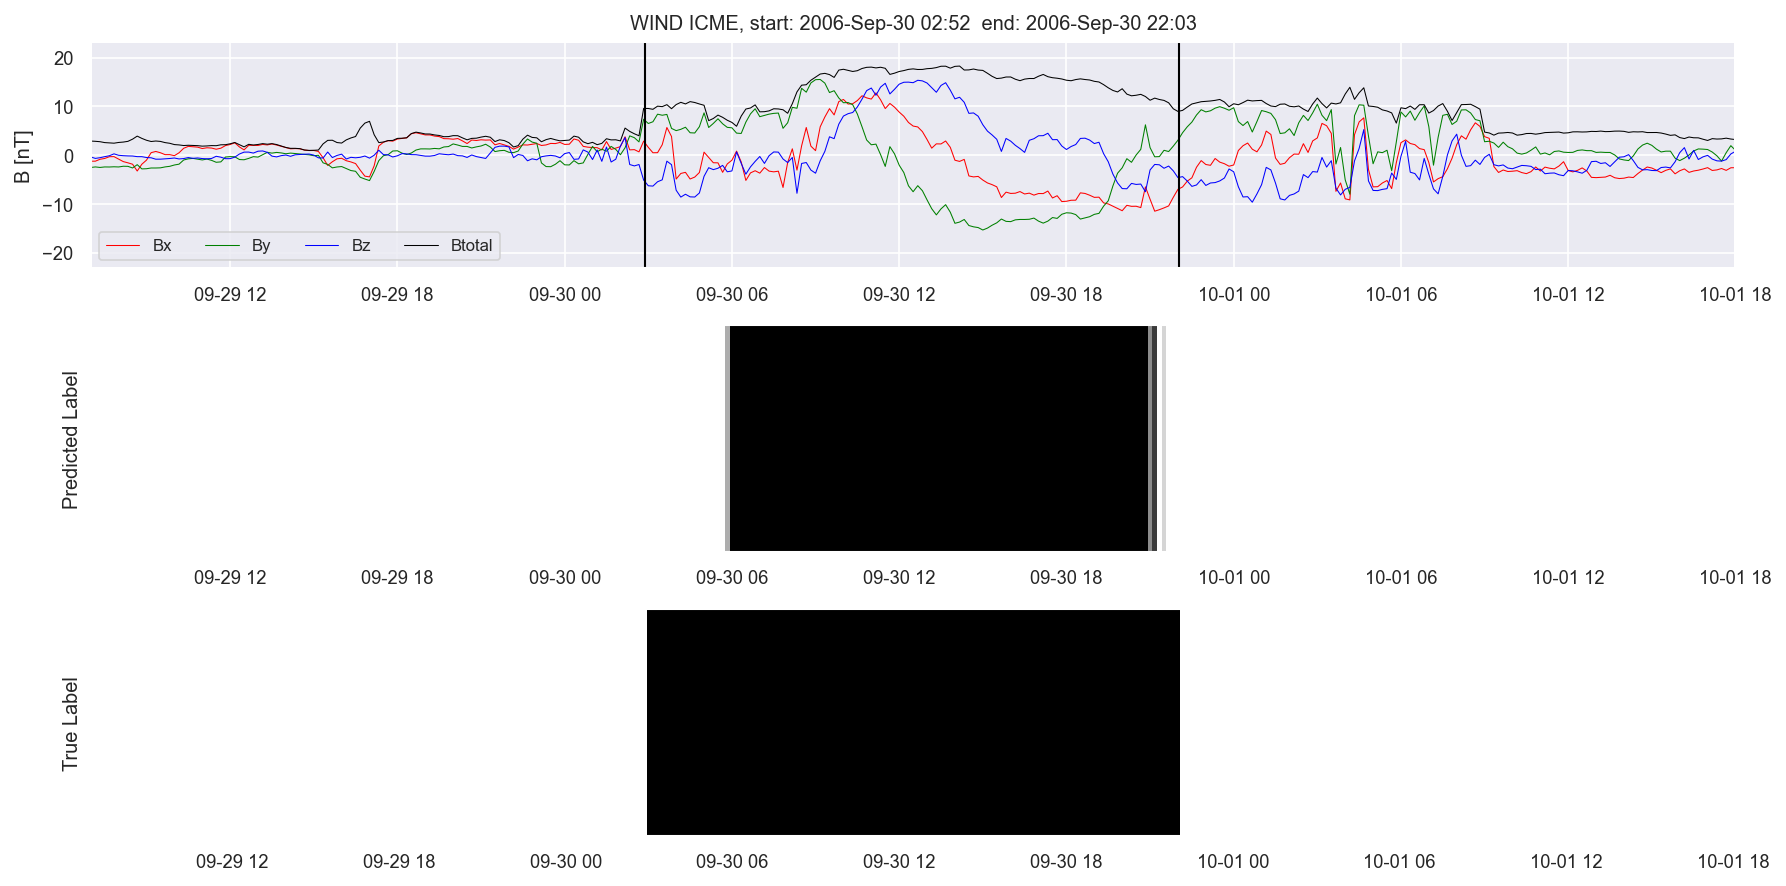

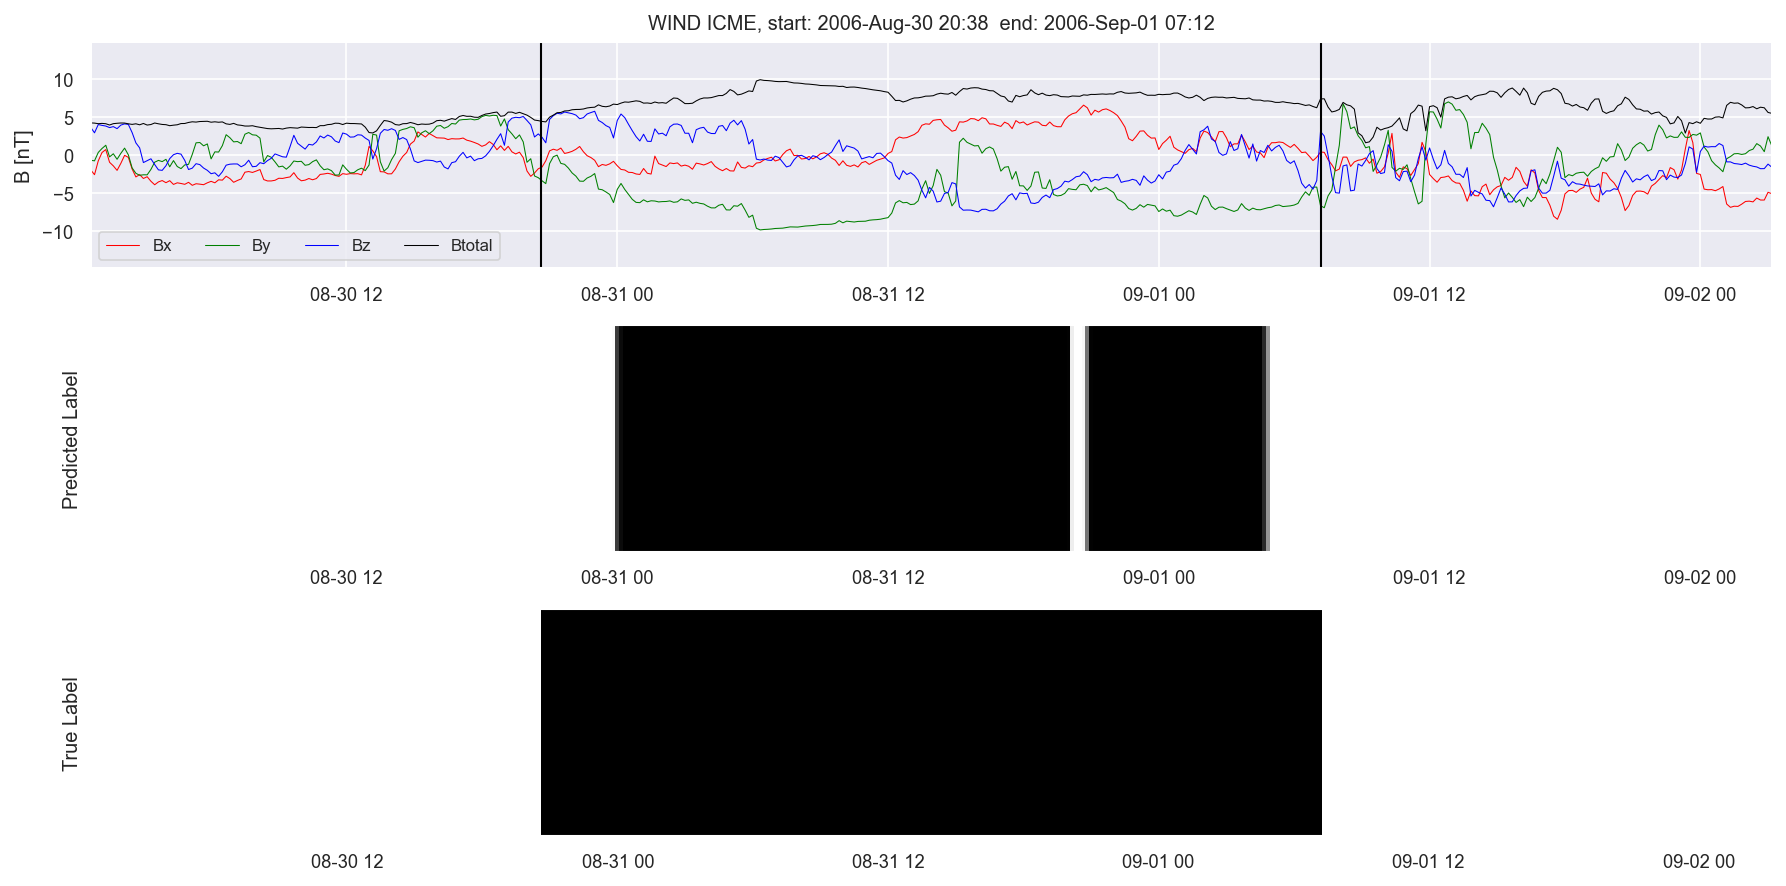

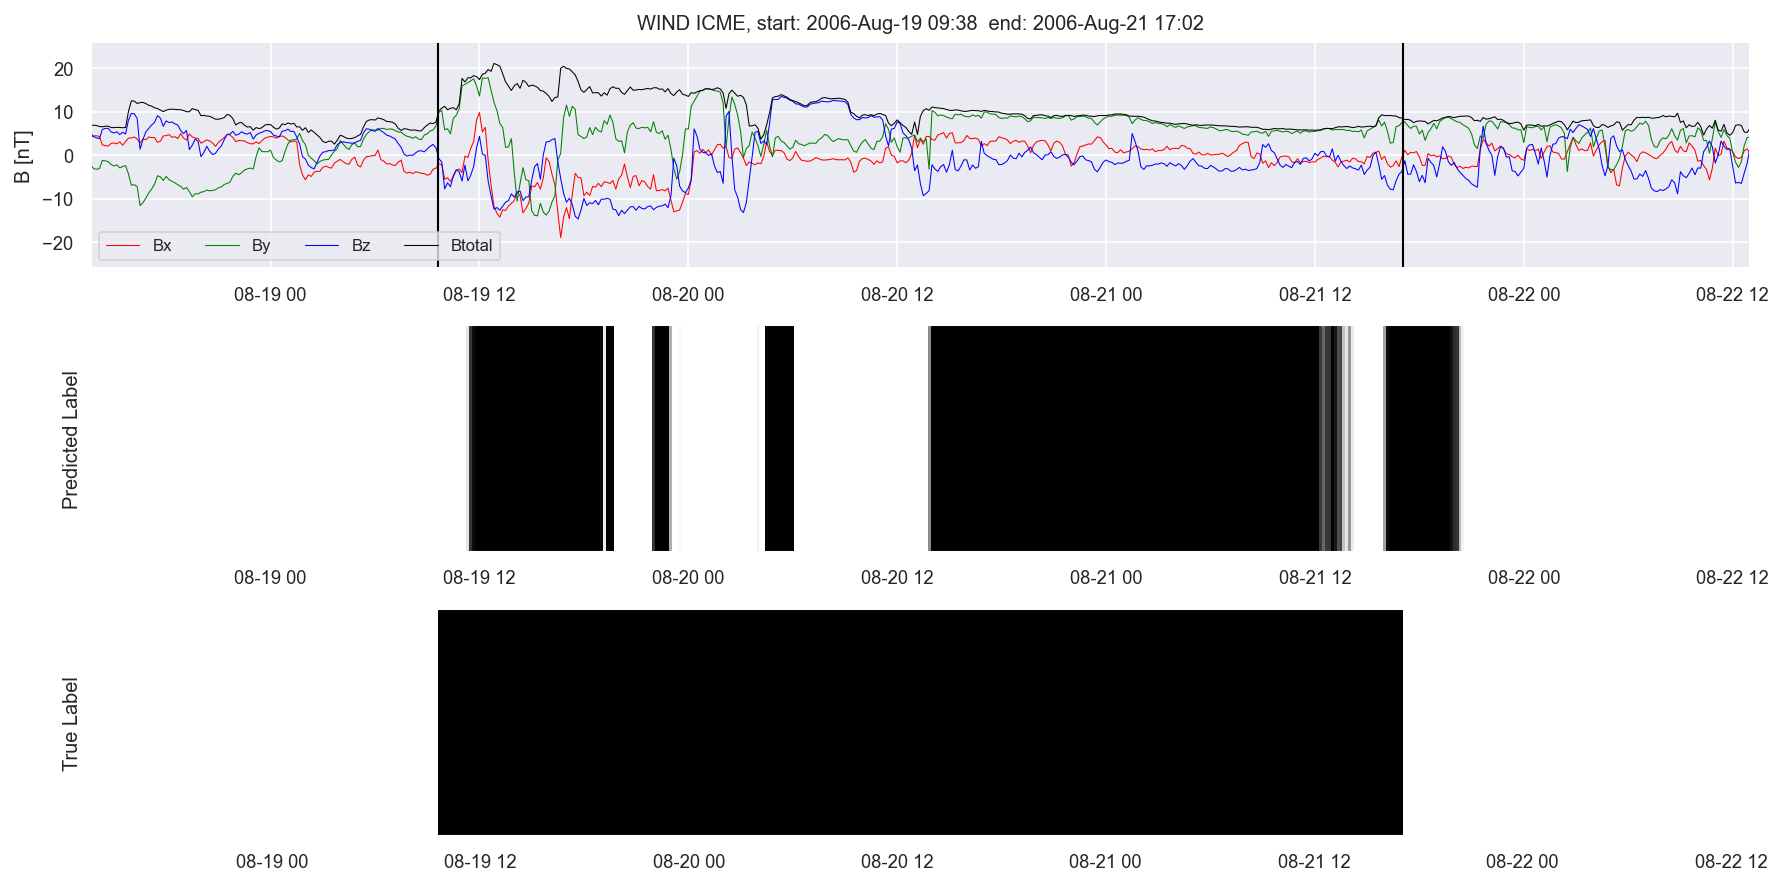

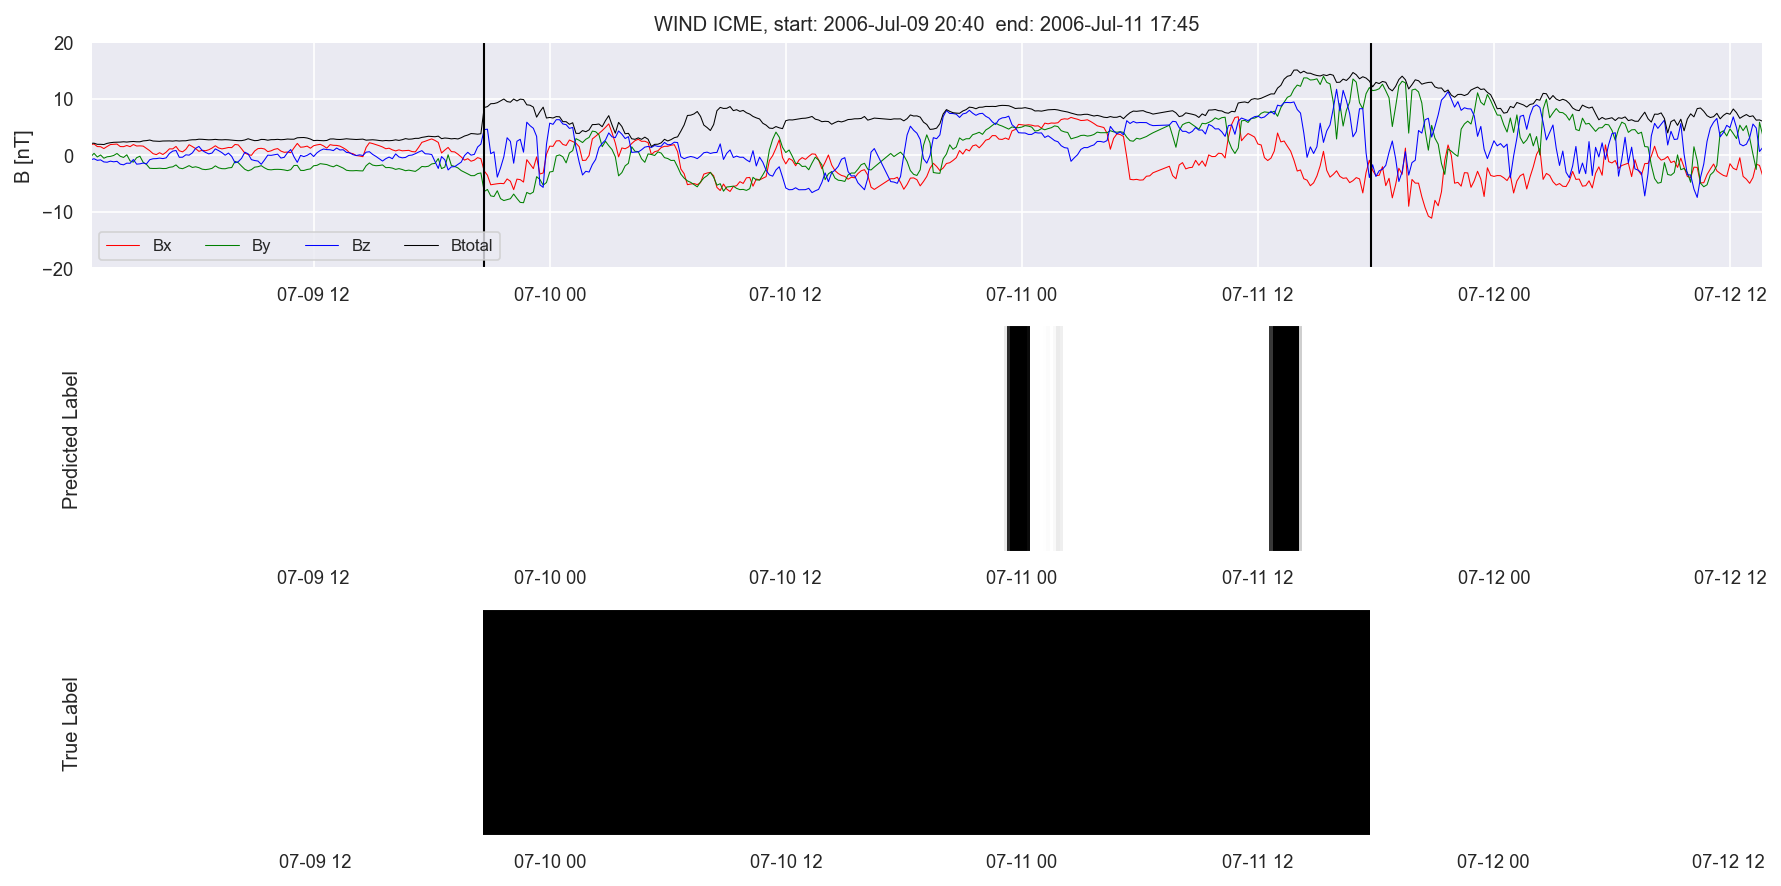

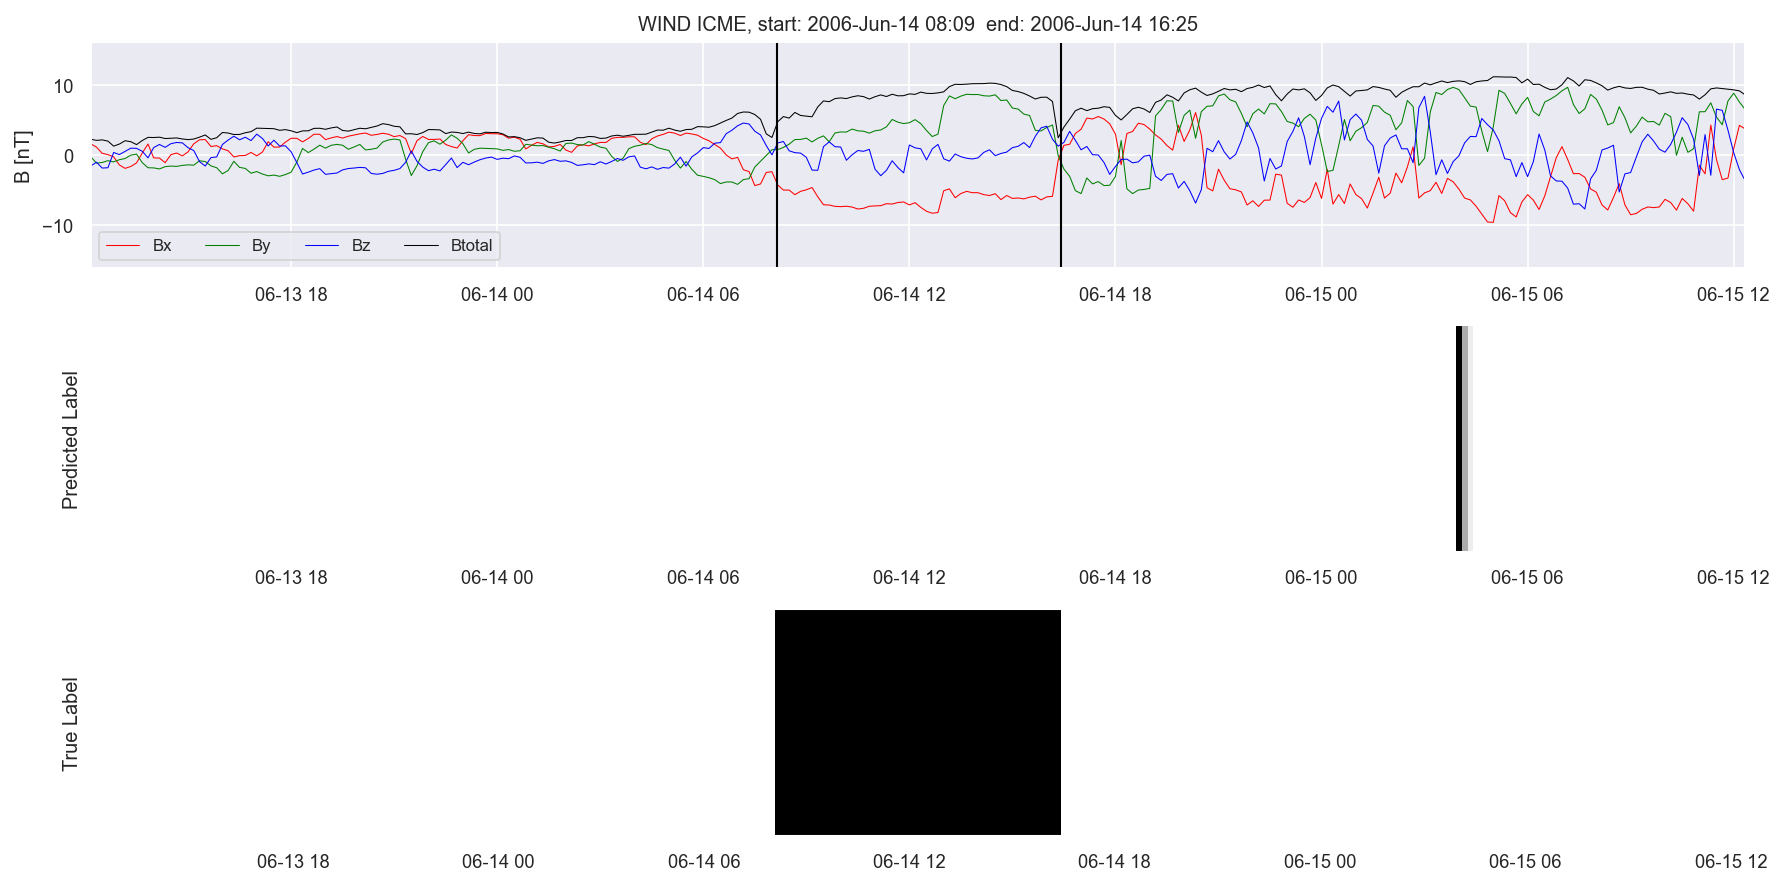

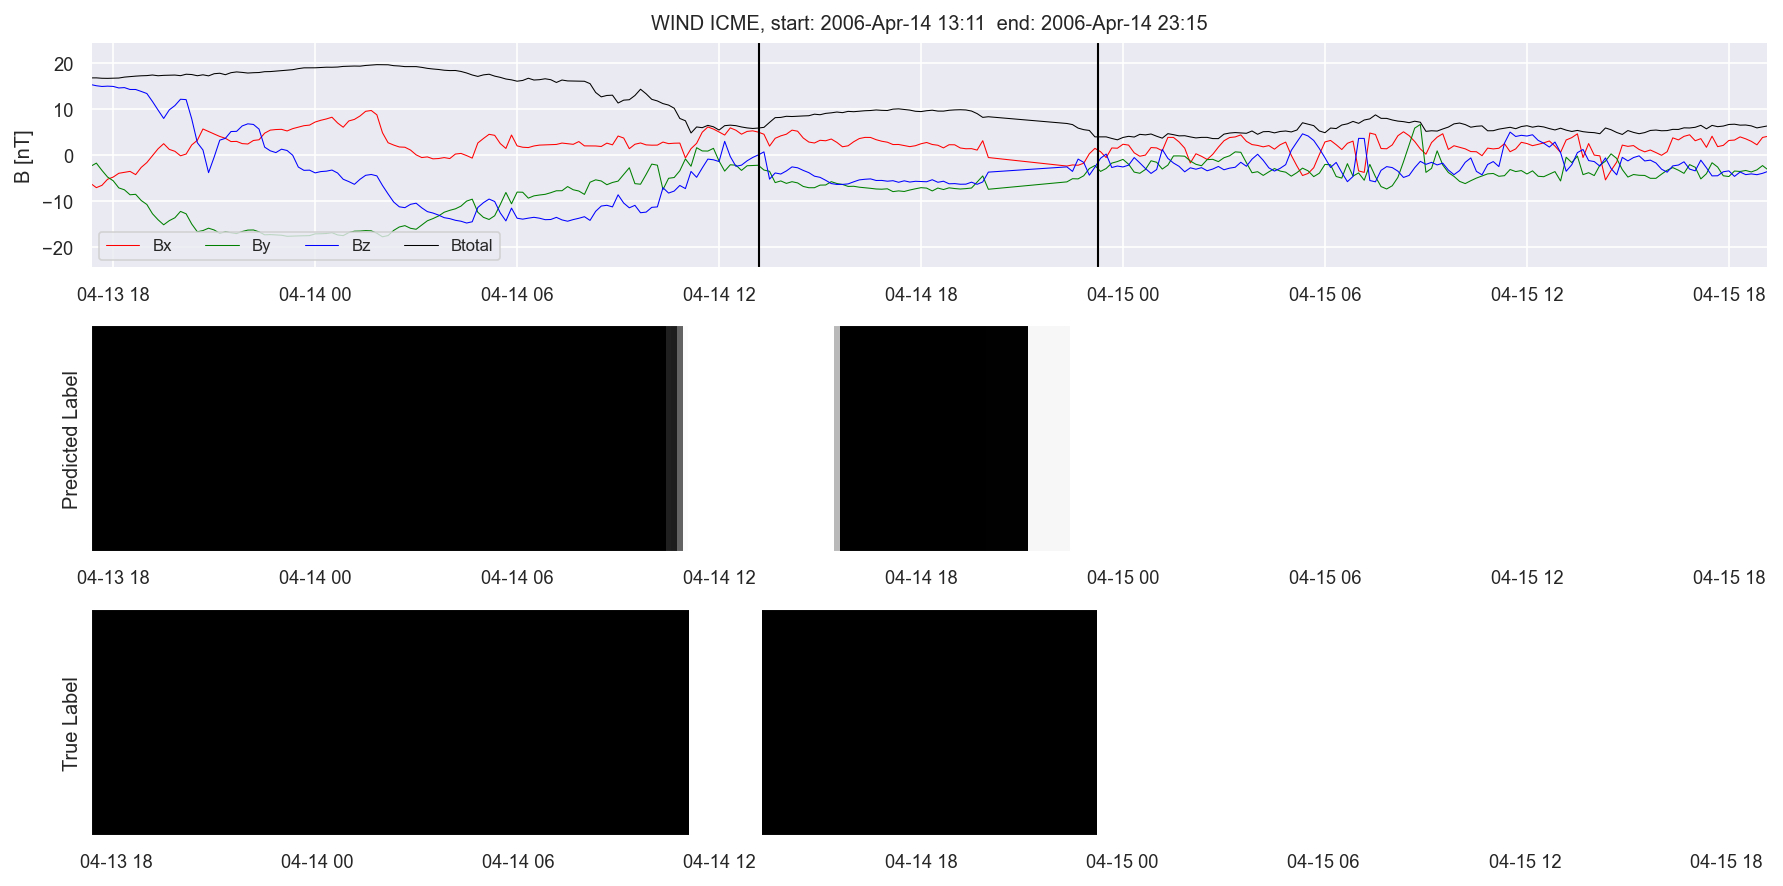

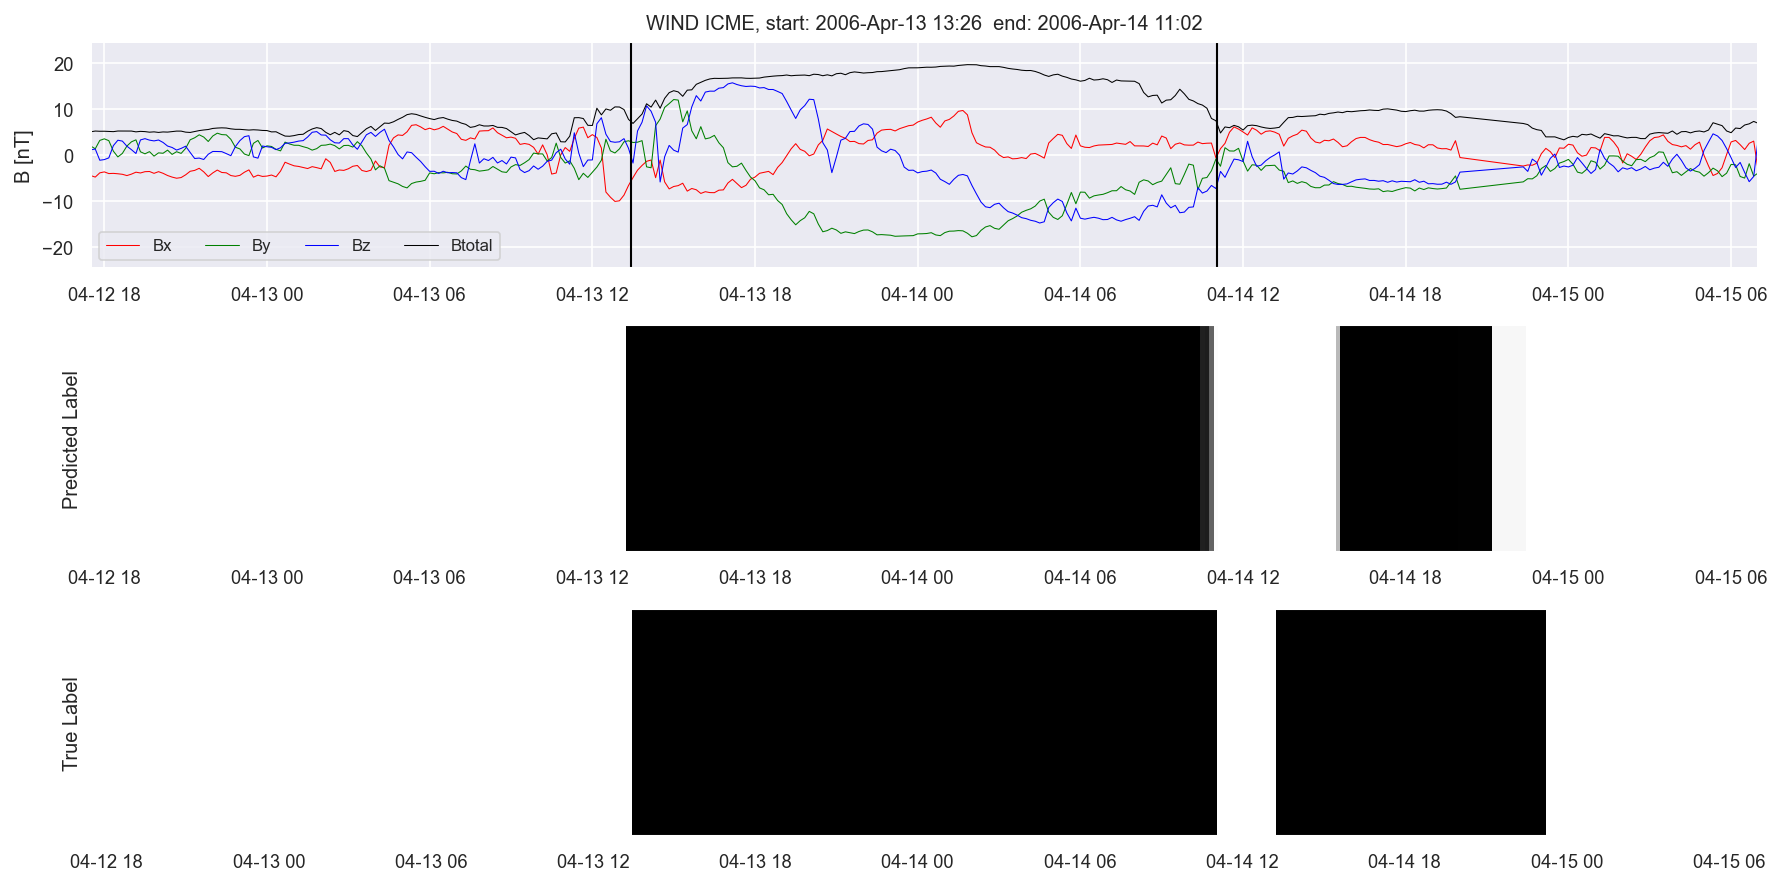

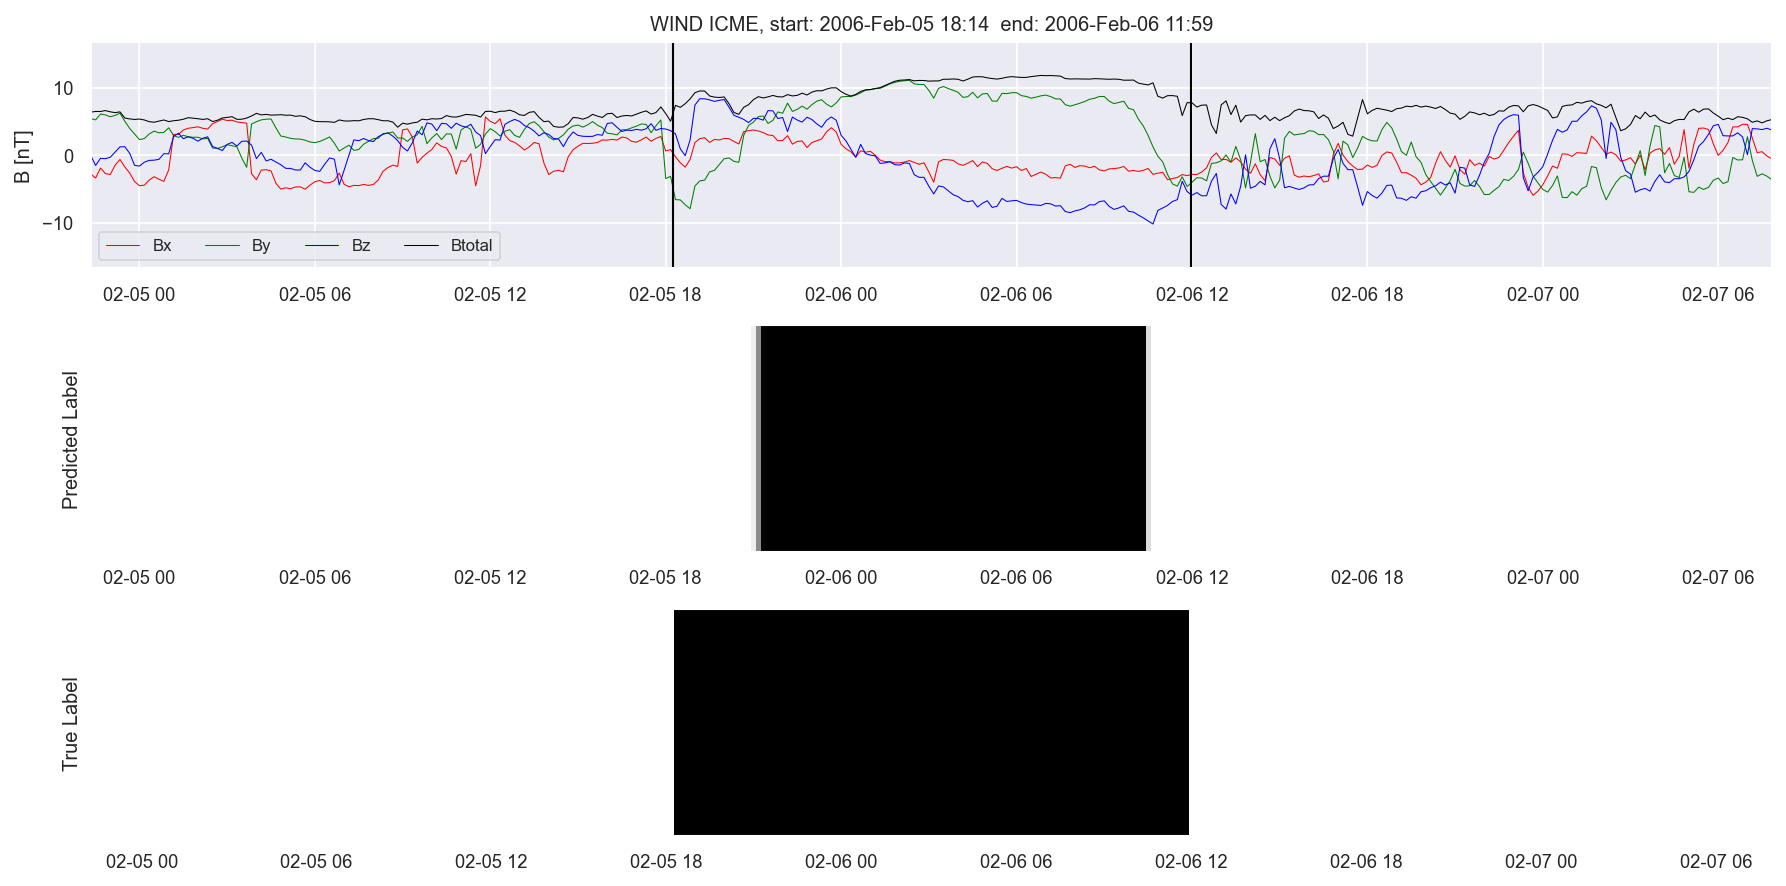

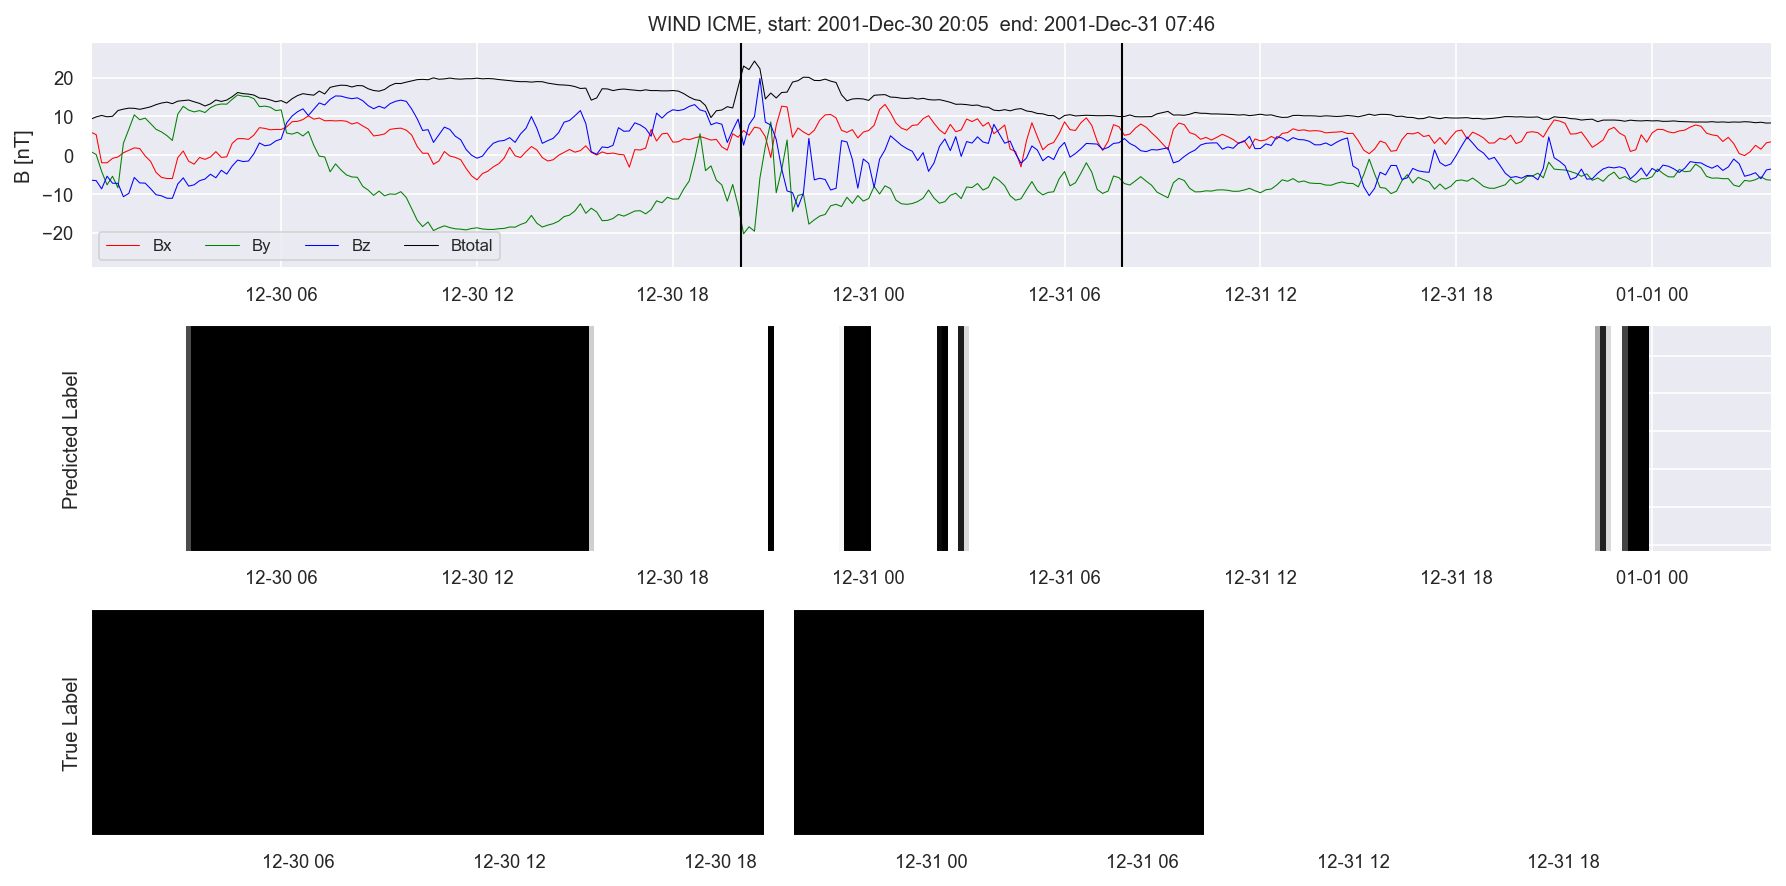

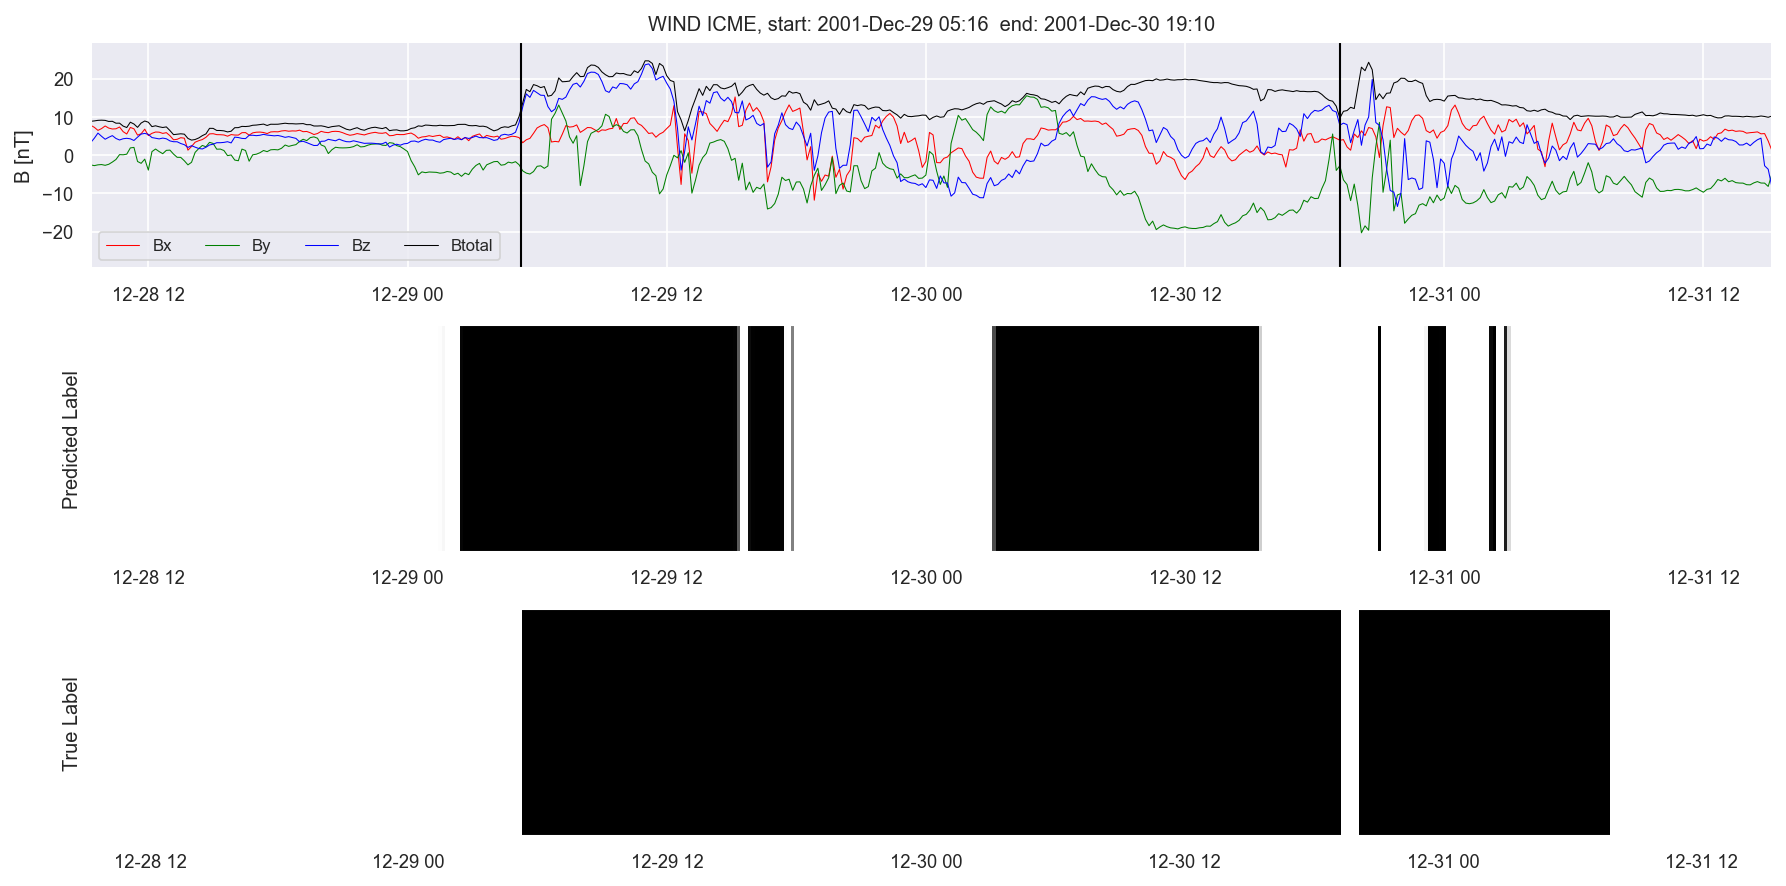

In [21]:
#Plot events and associated similarity values

for i in range(5, 15):
    test_clouds[i].plot_similaritymap(data.all_df,20,i,'WIND ',result)

In [22]:
# Score by event WIND

print('WIND:')

TP, FN, FP, detected = postprocess.evaluate(ICMEs, test_clouds, thres=0.1)
print('Precision is:',len(TP)/(len(TP)+len(FP)))
print('Recall is:',len(TP)/(len(TP)+len(FN)))
print('True Positives', len(TP))
print('False Negatives', len(FN))
print('False Positives', len(FP))

WIND:
Precision is: 0.5294117647058824
Recall is: 0.7941176470588235
True Positives 54
False Negatives 14
False Positives 48
